#### <font color="deepskyblue">Mission Data International</font>

<font color='lightskyblue'>L' entreprise française d'agroalimentaire, "La Poule qui chante", souhaite exporter ses poulets à l'international. Tous les pays sont envisageables.</font>

#### <font color="orange">Problématique : 

Quels sont les pays les plus favorables au développement de notre activité, c'est-à-dire aptent à l'importation de nos poulets prêts à la consommation ? </font>

## <font color="deepskyblue">Pré-traitement de nos données</font>

<font color="pink">

1. Alimenter nos données selon l'analyse PESTEL

    - Conserver uniquement les données de 2017

    - Filtrer les produits alimentaires pour ne garder que la volaille

    - Transformer nos dataframes avec "pivot_table" pour faciliter la sélection de nos features

4. Fusion des dataframes

4. Gestion des valeurs manquantes et format des variables

5. Analyse univariée et bivariée

6. Sélection de nos features

7. Détection des valeurs trés éloignées (outliers) avec IsolationForest

8. Suppression des outliers dans les colonnes 'exportations' et 'population'

9. Enregistrement de notre dataframe nettoyé et préparé pour analyse multivariée

</font>

In [25]:
import pandas as pd
import numpy as np
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.ensemble import IsolationForest

<font color="lightskyblue">Import et lecture des datasets</font>

- disponibilité alimentaire (production, exportation, importations, pertes, variation stocks, ...) 2017
- population 2017
- sous-nutrition 2017
- stabilité politique 2017
- PIB 2017

### <font color='pink'>1. Alimenter nos données selon l'analyse PESTEL</font>

### <font color='lightgreen'>Analyse démographique : Evolution de la population</font>

In [26]:
df_population = pd.read_csv('Population_2000_2018.csv', decimal=".")
df_population['Année'].values

array([2000, 2001, 2002, ..., 2016, 2017, 2018], dtype=int64)

Filtre sur l'année 2017

In [27]:
# Filtrer les données pour les années 2017 et 2018
df_population_ = df_population[(df_population['Année'] == 2017)]

# Afficher les premières lignes du DataFrame résultant
df_population_.head(3)


,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
17,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2017,2017,1000 personnes,36296.113,X,Sources internationales sûres,NaN
36,OA,Séries temporelles annuelles,202,Afrique du Sud,511,Population totale,3010,Population-Estimations,2017,2017,1000 personnes,57009.756,X,Sources internationales sûres,NaN
55,OA,Séries temporelles annuelles,3,Albanie,511,Population totale,3010,Population-Estimations,2017,2017,1000 personnes,2884.169,X,Sources internationales sûres,NaN


Convertion de la population en milliers d'habitants

In [28]:
# Convertir la population en milliers
df_population_['Valeur'] = (df_population_['Valeur'] * 1000).round()
df_population_['Valeur']

C:\Users\nbous\AppData\Local\Temp\ipykernel_21764\3468301856.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



17      36296113.0
36      57009756.0
55       2884169.0
74      41389189.0
93      82658409.0
           ...    
4333    29402484.0
4352    94600648.0
4371    27834819.0
4390    16853599.0
4409    14236595.0
Name: Valeur, Length: 236, dtype: float64

In [29]:
df_population_.head(2)

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
17,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2017,2017,1000 personnes,36296113.0,X,Sources internationales sûres,NaN
36,OA,Séries temporelles annuelles,202,Afrique du Sud,511,Population totale,3010,Population-Estimations,2017,2017,1000 personnes,57009756.0,X,Sources internationales sûres,NaN


Pivot_table de la population

In [30]:
# Pivoter le DataFrame
pivot_population_ = df_population_.pivot_table(index='Zone', columns='Année', values='Valeur')

# Afficher la table pivot
pivot_population_


Année,2017
Zone,
Afghanistan,36296113.0
Afrique du Sud,57009756.0
Albanie,2884169.0
Algérie,41389189.0
Allemagne,82658409.0
...,...
Îles Salomon,636039.0
Îles Turques-et-Caïques,37115.0
Îles Vierges américaines,104751.0


renommer les colonnes

In [31]:
# Renommer les colonnes de la table pivotée
pivot_population_.rename(columns={2017: 'population_2017'}, inplace=True)

# Afficher la table pivotée avec les colonnes renommées
print(pivot_population_)

Année                      population_2017
Zone                                      
Afghanistan                     36296113.0
Afrique du Sud                  57009756.0
Albanie                          2884169.0
Algérie                         41389189.0
Allemagne                       82658409.0
...                                    ...
Îles Salomon                      636039.0
Îles Turques-et-Caïques            37115.0
Îles Vierges américaines          104751.0
Îles Vierges britanniques          29577.0
Îles Wallis-et-Futuna              11900.0

[236 rows x 1 columns]


### <font color="lightgreen">Sous-Nutrition Sévère 2017</font>

In [32]:
pays_ss_nutrition = pd.read_csv('liste_pays_sous_nutrition_severe.csv')
pays_ss_nutrition.sort_values(by="Pourcentage_Sous_Nutrition", ascending=False).head(2)

,Unnamed: 0,Zone,Année,Population,sous_nutrition,Année médiane,ratio_sous_nutrition_mondiale,Pourcentage_Sous_Nutrition,Proportion_sous_nutrition_par pays
0,78,Haïti,2017-01-01,10982366.0,5300000.0,2017-01-01,7.1,48.26,48.26
1,157,République populaire démocratique de Corée,2017-01-01,25429825.0,12000000.0,2017-01-01,7.1,47.19,47.19


Pivot_table sur proportion_ss_nutrition_2017

In [33]:
# Créer la table pivot avec indexation sur la zone et pivot table sur Proportion_sous_nutrition_par pays
pivot_pays_ss_nutrition = pd.pivot_table(pays_ss_nutrition, 
                                         index='Zone', 
                                         values='Proportion_sous_nutrition_par pays').rename(columns={'Proportion_sous_nutrition_par pays': 'proportion_ss_nutrition_2017'})

# Afficher la table pivot
pivot_pays_ss_nutrition.sort_values(by="proportion_ss_nutrition_2017", ascending=False).head(10)


,proportion_ss_nutrition_2017
Zone,
Haïti,48.26
République populaire démocratique de Corée,47.19
Madagascar,41.06
Libéria,38.28
Lesotho,38.25
Tchad,37.96
Rwanda,35.06
Mozambique,32.81
Timor-Leste,32.17


In [34]:
import plotly.express as px

# Réinitialiser l'index pour le DataFrame pivot_pays_ss_nutrition afin que "Zone" devienne une colonne
pivot_pays_ss_nutrition_reset = pivot_pays_ss_nutrition.reset_index()

# Tracer le boxplot avec Plotly Express
fig = px.box(pivot_pays_ss_nutrition_reset, y='proportion_ss_nutrition_2017', labels={'proportion_ss_nutrition_2017': 'Proportion de sous-nutrition'}, hover_data={'Zone': True, 'proportion_ss_nutrition_2017': ':.2f'})

# Afficher le graphique
fig.show()


In [35]:
# Calcul de l'écart interquartile (IQR)
Q1 = pivot_pays_ss_nutrition['proportion_ss_nutrition_2017'].quantile(0.25)
Q3 = pivot_pays_ss_nutrition['proportion_ss_nutrition_2017'].quantile(0.75)
IQR = Q3 - Q1

print("Écart interquartile (IQR) :", IQR)


Écart interquartile (IQR) : 7.525


In [36]:
# Calcul de la moyenne et de l'écart type
mean = pivot_pays_ss_nutrition['proportion_ss_nutrition_2017'].mean()
std_dev = pivot_pays_ss_nutrition['proportion_ss_nutrition_2017'].std()

# Calcul du z-score pour chaque observation
pivot_pays_ss_nutrition['z_score'] = (pivot_pays_ss_nutrition['proportion_ss_nutrition_2017'] - mean) / std_dev

# Tri du DataFrame par z-score le plus élevé
sorted_df = pivot_pays_ss_nutrition.sort_values(by='z_score', ascending=False)

# Affichage du DataFrame trié
sorted_df.head(30)


,proportion_ss_nutrition_2017,z_score
Zone,,
Haïti,48.26,4.250580
République populaire démocratique de Corée,47.19,4.143350
Madagascar,41.06,3.529029
Libéria,38.28,3.250430
Lesotho,38.25,3.247424
Tchad,37.96,3.218361
Rwanda,35.06,2.927737
Mozambique,32.81,2.702252
Timor-Leste,32.17,2.638114


In [37]:
# Définir le seuil z
seuil_z = 1

# Identifier les observations qui dépassent le seuil
observations_depassement_seuil = sorted_df[sorted_df['z_score'] > seuil_z]

# Afficher les observations dépassant le seuil
print("Observations dont le z-score dépasse le seuil de 1 :\n", observations_depassement_seuil)


Observations dont le z-score dépasse le seuil de 1 :
                                             proportion_ss_nutrition_2017   
Zone                                                                       
Haïti                                                              48.26  \
République populaire démocratique de Corée                         47.19   
Madagascar                                                         41.06   
Libéria                                                            38.28   
Lesotho                                                            38.25   
Tchad                                                              37.96   
Rwanda                                                             35.06   
Mozambique                                                         32.81   
Timor-Leste                                                        32.17   
Afghanistan                                                        28.93   
Congo                             

In [38]:
# Récupérer les indices des observations dépassant le seuil
indices_a_supprimer = observations_depassement_seuil.index

# Supprimer les lignes correspondantes de merged_df
pivot_pays_ss_nutrition = pivot_pays_ss_nutrition.drop(indices_a_supprimer)

# Afficher le DataFrame mis à jour
pivot_pays_ss_nutrition.shape


(176, 2)

### <font color="lightgreen">Disponibilité alimentaire (df_food_available)</font>

Import et lecture

In [39]:
df_food_available = pd.read_csv('DisponibiliteAlimentaire_2017.csv', decimal=".")
df_food_available.head(2)

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
0,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5511,Production,2511,Blé et produits,2017,2017,Milliers de tonnes,4281.0,S,Données standardisées
1,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5611,Importations - Quantité,2511,Blé et produits,2017,2017,Milliers de tonnes,2302.0,S,Données standardisées


Filtrer sur la Viande de Volailles

Listing des produits

In [40]:
# Obtenir toutes les valeurs uniques de la colonne "Produit"
produits_uniques = df_food_available['Produit'].unique()
print(f"Nous obtenons {len(produits_uniques)} produits!")
print(f"Nous obtenons {produits_uniques} produits!")

Nous obtenons 98 produits!
Nous obtenons ['Blé et produits' 'Riz et produits' 'Orge et produits' 'Maïs et produits'
 'Seigle et produits' 'Avoine' 'Millet et produits' 'Sorgho et produits'
 'Céréales, Autres' 'Pommes de Terre et produits' 'Ignames' 'Racines nda'
 'Sucre, canne' 'Sucre, betterave' 'Sucre Eq Brut' 'Edulcorants Autres'
 'Miel' 'Haricots' 'Pois' 'Légumineuses Autres et produits'
 'Noix et produits' 'Soja' 'Arachides Decortiquees' 'Graines de tournesol'
 'Graines Colza/Moutarde' 'Graines de coton' 'Coco (Incl Coprah)' 'Sésame'
 'Olives' 'Plantes Oleiferes, Autre' 'Huile de Soja' "Huile d'Arachide"
 'Huile de Tournesol' 'Huile de Colza&Moutarde' 'Huile Graines de Coton'
 'Huile de Palmistes' 'Huile de Palme' 'Huile de Coco' 'Huile de Sésame'
 "Huile d'Olive" 'Huile de Son de Riz' 'Huile de Germe de Maïs'
 'Huil Plantes Oleif Autr' 'Tomates et produits' 'Oignons'
 'Légumes, Autres' 'Oranges, Mandarines' 'Citrons & Limes et produits'
 'Pamplemousse et produits' 'Agrumes, Autre

Filtrer 'df_food_available' sur "Viande de Volailles"

In [41]:
# Filtrer les données pour la "Viande de Volailles"
viande_volailles = df_food_available[df_food_available['Produit'] == 'Viande de Volailles']
viande_volailles.head(2)

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
651,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5511,Production,2734,Viande de Volailles,2017,2017,Milliers de tonnes,28.0,S,Données standardisées
652,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5611,Importations - Quantité,2734,Viande de Volailles,2017,2017,Milliers de tonnes,29.0,S,Données standardisées


In [42]:
# Obtenir toutes les valeurs uniques de la colonne "élément"
element_ = df_food_available['Élément'].unique()
print(f"Nous obtenons {len(element_)} éléments.")
print(f"Nous obtenons {element_}")

Nous obtenons 17 éléments.
Nous obtenons ['Production' 'Importations - Quantité' 'Variation de stock'
 'Exportations - Quantité' 'Disponibilité intérieure'
 'Aliments pour animaux' 'Semences' 'Pertes' 'Résidus' 'Nourriture'
 'Disponibilité alimentaire en quantité (kg/personne/an)'
 'Disponibilité alimentaire (Kcal/personne/jour)'
 'Disponibilité de protéines en quantité (g/personne/jour)'
 'Disponibilité de matière grasse en quantité (g/personne/jour)'
 'Traitement' 'Autres utilisations (non alimentaire)'
 'Alimentation pour touristes']


Filtrer sur "Elément" pour ne garder que les valeurs : 'Production', 'Exportations', 'Importations - Quantité', 'Disponibilité intérieure'


In [43]:
# éléments à conserver pour la consommation des populations humaines : rejet des valeurs pour animaux, traitement, autres utilisations
element_kept = ['Production', 'Exportations - Quantité' ,'Importations - Quantité', 'Disponibilité intérieure']

# Filtrer les données pour les éléments à conserver
df_food_available = viande_volailles[viande_volailles['Élément'].isin(element_kept)]
df_food_available.head()

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
651,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5511,Production,2734,Viande de Volailles,2017,2017,Milliers de tonnes,28.0,S,Données standardisées
652,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5611,Importations - Quantité,2734,Viande de Volailles,2017,2017,Milliers de tonnes,29.0,S,Données standardisées
654,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5301,Disponibilité intérieure,2734,Viande de Volailles,2017,2017,Milliers de tonnes,57.0,S,Données standardisées
1704,FBS,Nouveaux Bilans Alimentaire,202,Afrique du Sud,5511,Production,2734,Viande de Volailles,2017,2017,Milliers de tonnes,1667.0,S,Données standardisées
1705,FBS,Nouveaux Bilans Alimentaire,202,Afrique du Sud,5611,Importations - Quantité,2734,Viande de Volailles,2017,2017,Milliers de tonnes,514.0,S,Données standardisées


In [44]:
unites = df_food_available['Unité'].unique()
print(f"Nous obtenons {len(unites)} unités!")
print(f"Nous obtenons les unités suivantes : {unites}")

Nous obtenons 1 unités!
Nous obtenons les unités suivantes : ['Milliers de tonnes']


Convertir milliers de tonnes => Kg

In [45]:
# Colonnes à convertir en kilogrammes
colonnes_a_convertir = ['Production', 'Exportations - Quantité' ,'Importations - Quantité', 'Disponibilité intérieure']

# Convertir les valeurs en kilogrammes
df_food_available.loc[df_food_available['Élément'].isin(colonnes_a_convertir), 'Valeur'] *= 1000000


In [46]:
df_food_available.head(2)

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
651,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5511,Production,2734,Viande de Volailles,2017,2017,Milliers de tonnes,28000000.0,S,Données standardisées
652,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5611,Importations - Quantité,2734,Viande de Volailles,2017,2017,Milliers de tonnes,29000000.0,S,Données standardisées


RENOMMER LA COLONNE VALEUR EN VALEUR EN MILLIERS DE TONNES

In [47]:
df_food_available = df_food_available.rename(columns={'Valeur': 'Valeur_en_milliers_de_tonnes'})
df_food_available.head(2)

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur_en_milliers_de_tonnes,Symbole,Description du Symbole
651,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5511,Production,2734,Viande de Volailles,2017,2017,Milliers de tonnes,28000000.0,S,Données standardisées
652,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5611,Importations - Quantité,2734,Viande de Volailles,2017,2017,Milliers de tonnes,29000000.0,S,Données standardisées


Nouvelle dimension de "df_food_available"

In [48]:
df_food_available.shape
print(f"df_food_available has {df_food_available.shape[0]} rows and {df_food_available.shape[1]} columns !")

df_food_available has 643 rows and 14 columns !


Nombre de pays

In [49]:
nombre_de_pays = df_food_available["Zone"].nunique()
print('Nombre de pays :', nombre_de_pays)

Nombre de pays : 170


Pivot_table df_food_available

In [50]:
# Pivoter le DataFrame
pivot_df_food_available = pd.pivot_table(df_food_available, 
                                         index='Zone',
                                         columns='Élément', 
                                         values='Valeur_en_milliers_de_tonnes').reset_index()

# Remplacer l'index par la colonne "Zone"
pivot_df_food_available.set_index('Zone', inplace=True)

# Afficher le DataFrame pivoté avec les modifications
pivot_df_food_available


Élément,Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Production
Zone,,,,
Afghanistan,5.700000e+07,NaN,29000000.0,2.800000e+07
Afrique du Sud,2.118000e+09,6.300000e+07,514000000.0,1.667000e+09
Albanie,4.700000e+07,0.000000e+00,38000000.0,1.300000e+07
Algérie,2.770000e+08,0.000000e+00,2000000.0,2.750000e+08
Allemagne,1.739000e+09,6.460000e+08,842000000.0,1.514000e+09
...,...,...,...,...
Émirats arabes unis,4.120000e+08,9.400000e+07,433000000.0,4.800000e+07
Équateur,3.410000e+08,0.000000e+00,0.0,3.400000e+08
États-Unis d'Amérique,1.826600e+10,3.692000e+09,123000000.0,2.191400e+10


In [51]:
# Renommer les colonnes
pivot_df_food_available = pivot_df_food_available.rename(columns={
    'Disponibilité intérieure': 'Disponibilité en kg',
    'Importations - Quantité': 'Importation en kg',
    'Production': 'Production en kg',
    'Exportations - Quantité': 'Exportations en kg',
})

# Afficher le DataFrame pivoté avec les colonnes renommées
pivot_df_food_available


Élément,Disponibilité en kg,Exportations en kg,Importation en kg,Production en kg
Zone,,,,
Afghanistan,5.700000e+07,NaN,29000000.0,2.800000e+07
Afrique du Sud,2.118000e+09,6.300000e+07,514000000.0,1.667000e+09
Albanie,4.700000e+07,0.000000e+00,38000000.0,1.300000e+07
Algérie,2.770000e+08,0.000000e+00,2000000.0,2.750000e+08
Allemagne,1.739000e+09,6.460000e+08,842000000.0,1.514000e+09
...,...,...,...,...
Émirats arabes unis,4.120000e+08,9.400000e+07,433000000.0,4.800000e+07
Équateur,3.410000e+08,0.000000e+00,0.0,3.400000e+08
États-Unis d'Amérique,1.826600e+10,3.692000e+09,123000000.0,2.191400e+10


Valeurs manquantes : pivot_df_food_available

In [52]:
pivot_df_food_available.isnull().sum()
# un adulte a besoin de 58g de protéines/jour en moyenne
# source : https://www.futura-sciences.com/sante/questions-reponses/nutrition-proteines-t-on-reellement-besoin-14827/

Élément
Disponibilité en kg     0
Exportations en kg     35
Importation en kg       0
Production en kg        2
dtype: int64

### <font color="lightgreen">Stabilité Politique - 2017</font>

In [53]:
stabilite_politique = pd.read_csv('stabilite_politique_absence_violence.csv', decimal=".")
stabilite_politique.head(2)

,Code Domaine,Domaine,Code zone (M49),Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
0,FS,Données de la sécurité alimentaire,528,Pays-Bas (Royaume des),6125,Valeur,21032,Stabilité politique et absence de violence/ter...,2017,2017,indice,0.92,X,Ciffre de sources internationales,NaN
1,FS,Données de la sécurité alimentaire,4,Afghanistan,6125,Valeur,21032,Stabilité politique et absence de violence/ter...,2017,2017,indice,-2.80,X,Ciffre de sources internationales,NaN


Pivot_table df : 'stabilite_politique'

In [54]:
# Pivoter le DataFrame
pivot_stabilite_politique = pd.pivot_table(stabilite_politique, 
                                           index='Zone', 
                                           values='Valeur').rename(columns={'Valeur': 'indice_stabilite_politique_2017'})

# Afficher le DataFrame pivoté
pivot_stabilite_politique.sort_values(by='indice_stabilite_politique_2017', ascending=True).head(20)


,indice_stabilite_politique_2017
Zone,
Yémen,-2.94
Afghanistan,-2.80
République arabe syrienne,-2.62
Soudan du Sud,-2.45
Pakistan,-2.41
Libye,-2.36
Iraq,-2.31
République démocratique du Congo,-2.30
Somalie,-2.26


In [55]:
pivot_stabilite_politique.isnull().mean()

indice_stabilite_politique_2017    0.0
dtype: float64

In [56]:
pivot_stabilite_politique.shape

(196, 1)

### <font color="lightgreen">PIB 2017</font>

In [57]:
# Charger les données
pib_croissance = pd.read_csv('croissance_et_PIB_par_habitant.csv')
pib_croissance.head(3)

,Code Domaine,Domaine,Code zone (M49),Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
0,MK,Indicateurs macro,4,Afghanistan,6119,Valeur US $ par habitant,22008,Produit Intérieur Brut,2017,2017,US$,530.149831,X,Ciffre de sources internationales,NaN
1,MK,Indicateurs macro,4,Afghanistan,6129,Croissance annuelle US$,22008,Produit Intérieur Brut,2017,2017,%,4.865789,X,Ciffre de sources internationales,NaN
2,MK,Indicateurs macro,4,Afghanistan,61290,Croissance annuelle US$ par habitant,22008,Produit Intérieur Brut,2017,2017,%,1.902494,X,Ciffre de sources internationales,NaN


In [58]:
# Filtrer les données pour les années 2017 et 2023
pib_croissance_selected = pib_croissance[(pib_croissance['Élément'] == "Valeur US $ par habitant")]

# Pivoter les données pour avoir une structure avec 2017 et 2023 comme colonnes
pivot_pib_croissance = pib_croissance_selected.pivot_table(index='Zone', columns='Élément', values='Valeur')

# Afficher la table pivot
pivot_pib_croissance

Élément,Valeur US $ par habitant
Zone,
Afghanistan,530.149831
Afrique du Sud,6723.928582
Albanie,4521.752217
Algérie,4134.936055
Allemagne,44670.222282
...,...
Îles Cook,19868.295215
Îles Marshall,4515.261195
Îles Salomon,2283.581124


********************************************************************************************************************

### <font color='pink'>2. Fusion des dataframes</font>

In [59]:
# Fusionner avec pivot_df_food_available
merged_df = pd.merge(pivot_df_food_available, pivot_population_, on='Zone', how='inner')
merged_df = pd.merge(merged_df, pivot_pays_ss_nutrition, on='Zone', how='inner')
merged_df = pd.merge(merged_df, pivot_stabilite_politique, on='Zone', how='inner')
merged_df = pd.merge(merged_df, pivot_pib_croissance, on='Zone', how='inner')

# Afficher le DataFrame fusionné
merged_df.head()

,Disponibilité en kg,Exportations en kg,Importation en kg,Production en kg,population_2017,proportion_ss_nutrition_2017,z_score,indice_stabilite_politique_2017,Valeur US $ par habitant
Zone,,,,,,,,,
Afrique du Sud,2.118000e+09,63000000.0,514000000.0,1.667000e+09,57009756.0,5.44,-0.040644,-0.28,6723.928582
Albanie,4.700000e+07,0.0,38000000.0,1.300000e+07,2884169.0,3.47,-0.238068,0.38,4521.752217
Algérie,2.770000e+08,0.0,2000000.0,2.750000e+08,41389189.0,3.14,-0.271139,-0.92,4134.936055
Allemagne,1.739000e+09,646000000.0,842000000.0,1.514000e+09,82658409.0,0.00,-0.585816,0.59,44670.222282
Antigua-et-Barbuda,7.000000e+06,0.0,7000000.0,0.000000e+00,95426.0,0.00,-0.585816,0.75,16110.556281


In [60]:
merged_df.shape

(138, 9)

****************************************************************************************************************************************************

### <font color='pink'>3. Gestion des valeurs manquantes et format</font>

<font color="lightskyblue">Missingno : Visualiser les valeurs manquantes</font>

<Axes: >

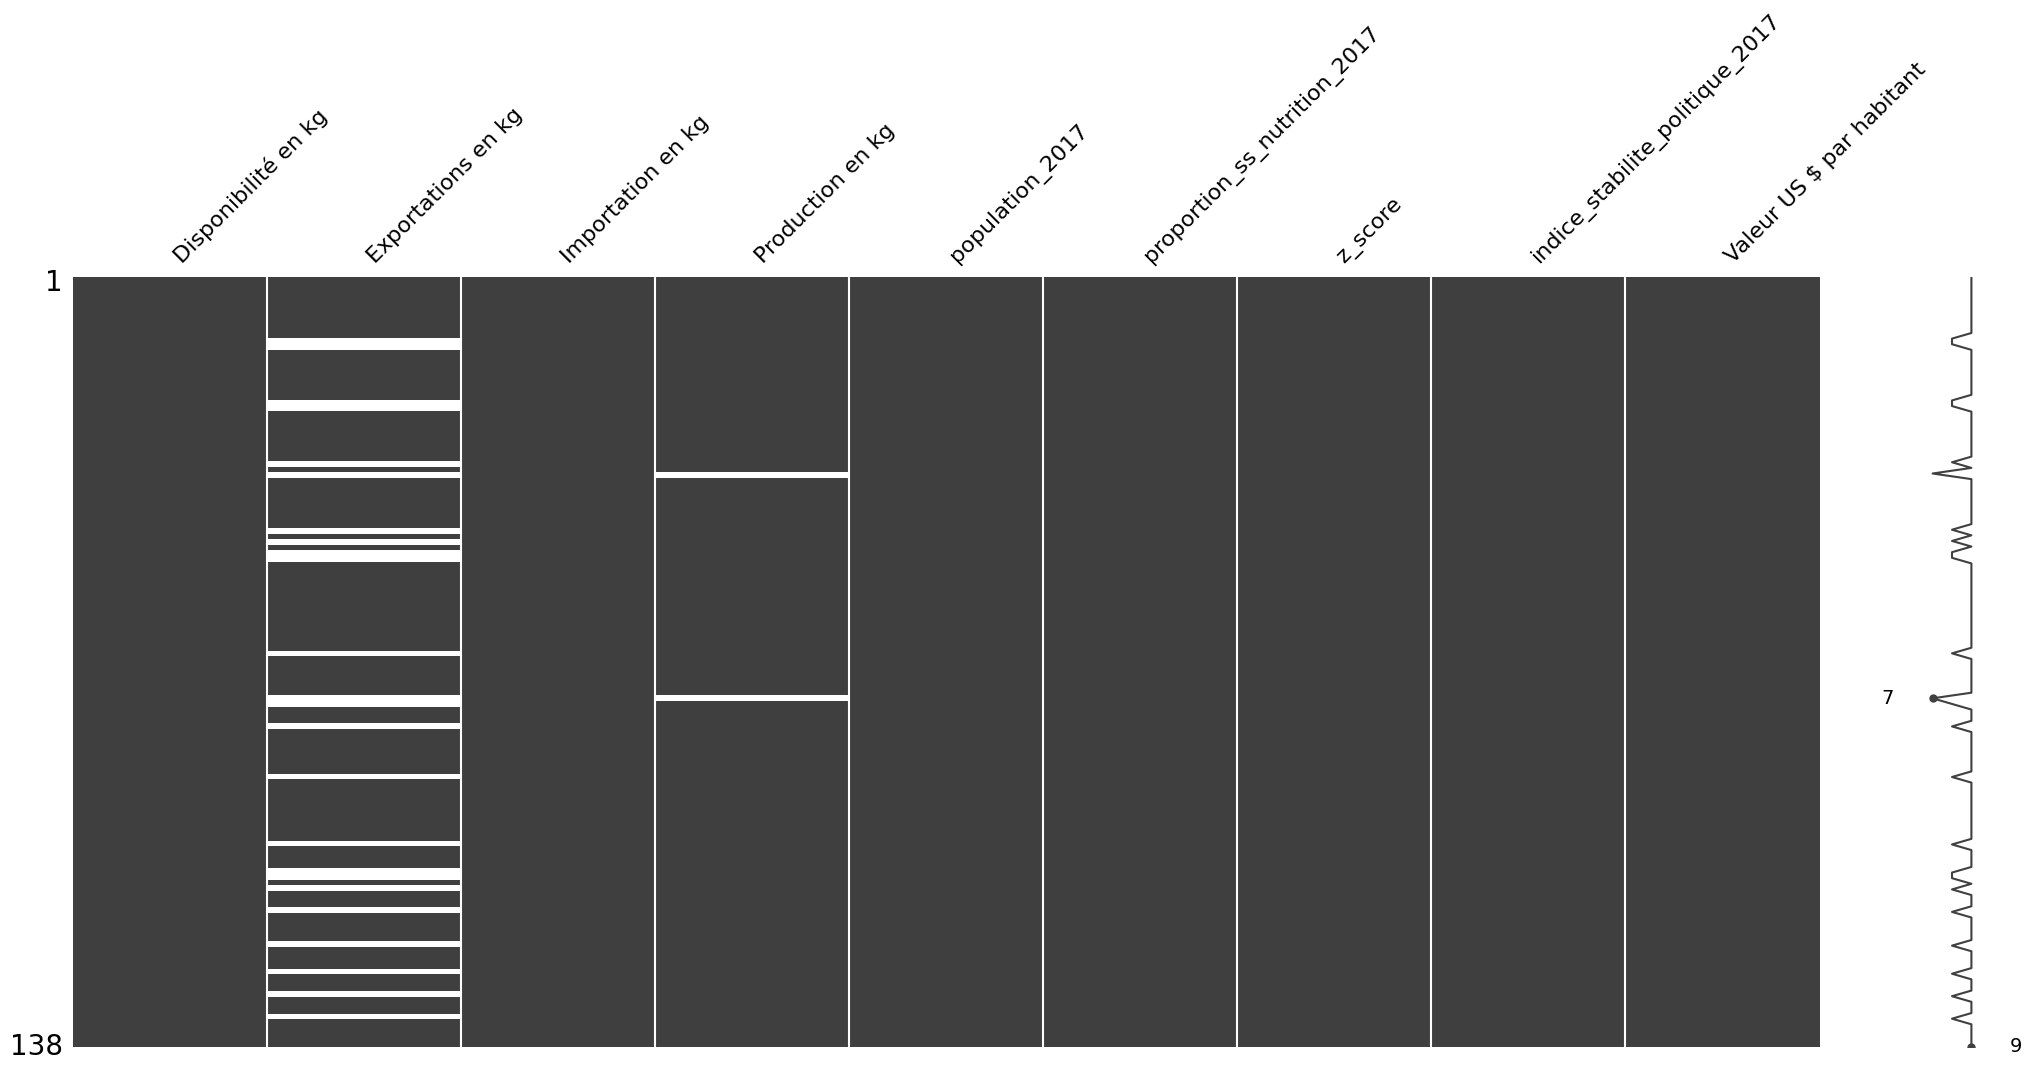

In [61]:
msno.matrix(merged_df)

<Axes: >

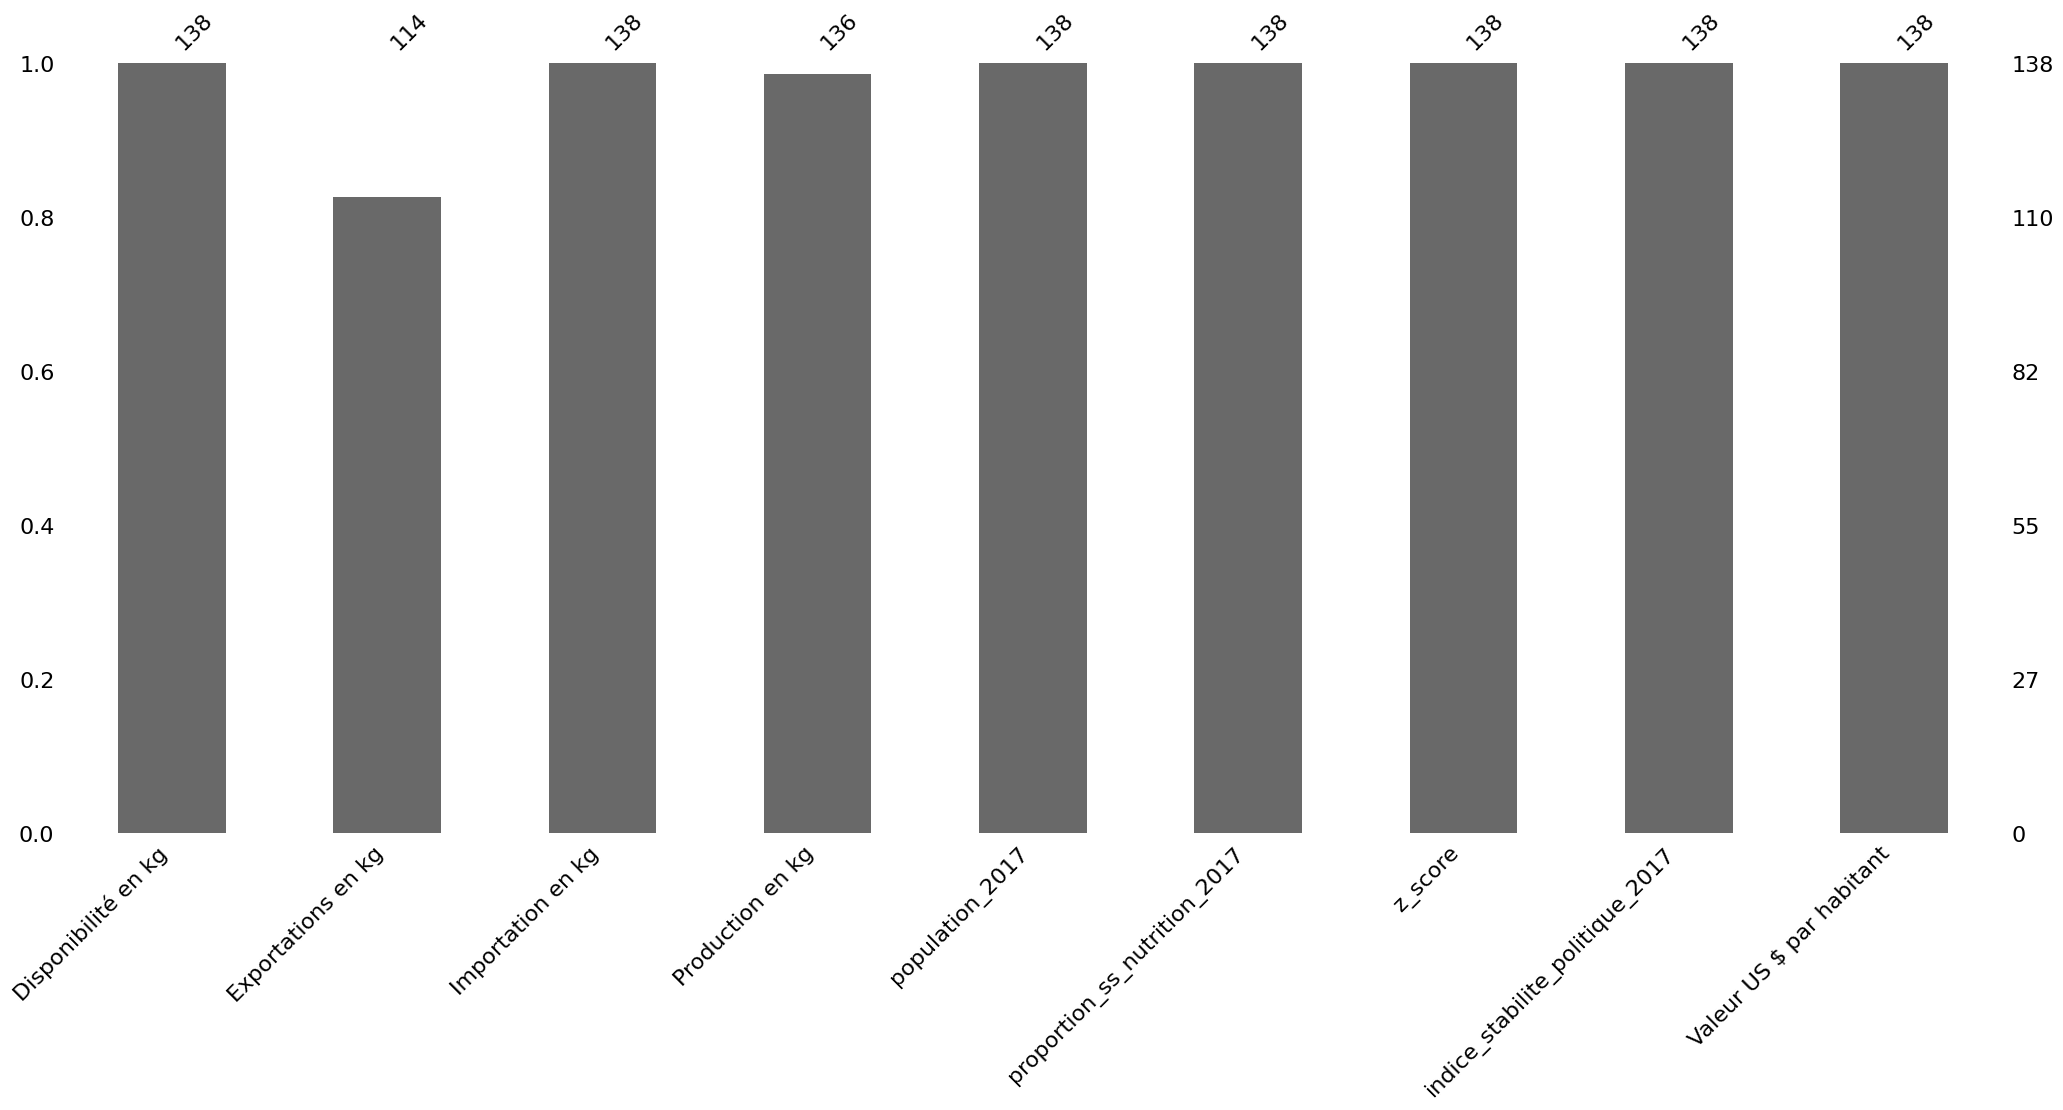

In [62]:
msno.bar(merged_df)

#### 3/ nombre de variables, nombre de valeurs non nulles, nombre de NaN, nombre de valeurs uniques, et type/format des variables

=> La fonction 'exploration_data' permet de rassembler les informations suivantes :
- colonnes du dataframe
- total des valeurs non nulles
- total des valeurs uniques
- format des variables
- total des valeurs manquantes
- % des valeurs nulles sur l'ensemble des données du dataframe

In [63]:
def exploration_data(df: pd.DataFrame):
    desc = df.columns.to_frame(name="colonne").set_index('colonne')
    desc['nombre de valeurs non nulles'] = df.notnull().sum() 
    desc['nombre de valeurs uniques'] = df.nunique() 
    desc['type de donnée'] = df.dtypes 
    desc['nombre de valeurs manquantes']=df.isna().mean()
    desc['pourcentage de valeurs nulles']=round((df.isna().sum()/df.shape[0]*100),2)
    return desc

In [64]:
exploration_data(merged_df)

,nombre de valeurs non nulles,nombre de valeurs uniques,type de donnée,nombre de valeurs manquantes,pourcentage de valeurs nulles
colonne,,,,,
Disponibilité en kg,138,114,float64,0.000000,0.00
Exportations en kg,114,48,float64,0.173913,17.39
Importation en kg,138,74,float64,0.000000,0.00
Production en kg,136,107,float64,0.014493,1.45
population_2017,138,138,float64,0.000000,0.00
proportion_ss_nutrition_2017,138,53,float64,0.000000,0.00
z_score,138,53,float64,0.000000,0.00
indice_stabilite_politique_2017,138,110,float64,0.000000,0.00
Valeur US $ par habitant,138,138,float64,0.000000,0.00


In [65]:
print(f"Nous obtenons un df fusionné de : {merged_df.shape[0]} lignes et {merged_df.shape[1]} colonnes !")

Nous obtenons un df fusionné de : 138 lignes et 9 colonnes !


In [66]:
# Appeler la fonction pour explorer les données
nan_located = exploration_data(merged_df)

# Filtrer le résumé pour les colonnes où il y a des valeurs manquantes
colonnes_manquantes = nan_located[nan_located['pourcentage de valeurs nulles'] > 0]
colonnes_manquantes


,nombre de valeurs non nulles,nombre de valeurs uniques,type de donnée,nombre de valeurs manquantes,pourcentage de valeurs nulles
colonne,,,,,
Exportations en kg,114,48,float64,0.173913,17.39
Production en kg,136,107,float64,0.014493,1.45


In [67]:
# Afficher le détail des valeurs manquantes pour chaque colonne
for colonne in colonnes_manquantes.index:
    print(f"Colonnes: {colonne}")
    print(merged_df[merged_df[colonne].isna()])
    print("\n")


Colonnes: Exportations en kg
                                 Disponibilité en kg  Exportations en kg   
Zone                                                                       
Bahamas                                   26000000.0                 NaN  \
Bangladesh                               250000000.0                 NaN   
Cabo Verde                                10000000.0                 NaN   
Cambodge                                  38000000.0                 NaN   
Cuba                                     342000000.0                 NaN   
Djibouti                                   3000000.0                 NaN   
Gambie                                     8000000.0                 NaN   
Grenade                                    8000000.0                 NaN   
Guinée                                    50000000.0                 NaN   
Guinée-Bissau                              4000000.0                 NaN   
Kiribati                                   2000000.0       

Récupérer les valeurs depuis le site de la FAO si disponible

Vérification remplacement des nans

In [68]:
# Créer un dictionnaire des zones avec des exportations en NaN
zones_exportations_nan = {}

# Parcourir les index du DataFrame pour trouver les zones avec des exportations en NaN
for zone in merged_df.index:
    valeur_exportation = merged_df.loc[zone, 'Exportations en kg']
    if pd.isna(valeur_exportation):  # Vérifier si l'exportation est NaN
        zones_exportations_nan[zone] = zones_exportations_nan.get(zone, 0) + 1

# Afficher le dictionnaire des zones avec des exportations en NaN
print(zones_exportations_nan)


{'Bahamas': 1, 'Bangladesh': 1, 'Cabo Verde': 1, 'Cambodge': 1, 'Cuba': 1, 'Djibouti': 1, 'Gambie': 1, 'Grenade': 1, 'Guinée': 1, 'Guinée-Bissau': 1, 'Kiribati': 1, 'Maldives': 1, 'Mali': 1, 'Mauritanie': 1, 'Népal': 1, 'République centrafricaine': 1, 'Saint-Vincent-et-les Grenadines': 1, 'Sainte-Lucie': 1, 'Sao Tomé-et-Principe': 1, 'Soudan': 1, 'Tadjikistan': 1, 'Turkménistan': 1, 'Vanuatu': 1, 'Zimbabwe': 1}


<font color='lightgreen'>=> Récupérer les valeurs des exportations sur le site de la FAO si elles existent</font>

In [69]:
nan_exportations = pd.read_csv('PRIX_QUANTITE_IMPORT_EXPORT_POULET.csv')

In [70]:
# Liste des pays avec des exportations en NaN
pays_exportations_nan = [
    'Afghanistan', 'Bahamas', 'Bangladesh', 'Burkina Faso', 'Cabo Verde', 'Cambodge', 'Gambie', 'Grenade', 'Guinée', 
    'Guinée-Bissau', 'Haïti', 'Kiribati', 'Madagascar', 'Malawi', 'Mali', 'Mauritanie', 'Mongolie', 'Mozambique', 'Népal', 
    'République-Unie de Tanzanie', 'Saint-Vincent-et-les Grenadines', 'Sainte-Lucie', 'Sao Tomé-et-Principe', 'Soudan', 
    'Tadjikistan', 'Timor-Leste', 'Vanuatu', 'Zimbabwe', 'Éthiopie'
]

# Filtrer le DataFrame pour obtenir les lignes correspondant à ces pays et aux exportations en NaN
nan_exportations = nan_exportations[(nan_exportations['Zone'].isin(pays_exportations_nan)) & (nan_exportations['Code Élément'] == 5910)]

# Afficher le résultat
print(nan_exportations)


    Code Domaine                       Domaine  Code zone (M49)          Zone   
2            TCL  Cultures et produits animaux                4   Afghanistan  \
54           TCL  Cultures et produits animaux               50    Bangladesh   
364          TCL  Cultures et produits animaux              454        Malawi   
514          TCL  Cultures et produits animaux              662  Sainte-Lucie   
576          TCL  Cultures et produits animaux              762   Tadjikistan   

     Code Élément                  Élément  Code Produit (CPC)   
2            5910  Exportations - Quantité               21121  \
54           5910  Exportations - Quantité               21121   
364          5910  Exportations - Quantité               21121   
514          5910  Exportations - Quantité               21121   
576          5910  Exportations - Quantité               21121   

                                   Produit  Code année  Année   Unité  Valeur   
2    Viande, poulet, fraîche ou réf

In [71]:
# Convertir les valeurs de l'exportation de tonnes en kg
nan_exportations['Valeur'] *= 1000

Remplacer les NaN par les valeurs de la FAO sur la quantité des exportations

In [72]:
# Liste des pays avec leurs valeurs en kg
pays_valeurs_kg = {
    'Afghanistan': 36990.0,
    'Bangladesh': 820.0,
    'Malawi': 204400.0,
    'Sainte-Lucie': 1520.0,
    'Tadjikistan': 30.0
}

# Mettre à jour les valeurs dans merged_df
for pays, valeur_kg in pays_valeurs_kg.items():
    merged_df.loc[merged_df.index == pays, 'Exportations en kg'] = valeur_kg

# Afficher le DataFrame mis à jour
merged_df


,Disponibilité en kg,Exportations en kg,Importation en kg,Production en kg,population_2017,proportion_ss_nutrition_2017,z_score,indice_stabilite_politique_2017,Valeur US $ par habitant
Zone,,,,,,,,,
Afrique du Sud,2.118000e+09,6.300000e+07,514000000.0,1.667000e+09,57009756.0,5.44,-0.040644,-0.28,6723.928582
Albanie,4.700000e+07,0.000000e+00,38000000.0,1.300000e+07,2884169.0,3.47,-0.238068,0.38,4521.752217
Algérie,2.770000e+08,0.000000e+00,2000000.0,2.750000e+08,41389189.0,3.14,-0.271139,-0.92,4134.936055
Allemagne,1.739000e+09,6.460000e+08,842000000.0,1.514000e+09,82658409.0,0.00,-0.585816,0.59,44670.222282
Antigua-et-Barbuda,7.000000e+06,0.000000e+00,7000000.0,0.000000e+00,95426.0,0.00,-0.585816,0.75,16110.556281
...,...,...,...,...,...,...,...,...,...
Égypte,1.250000e+09,1.000000e+06,110000000.0,1.118000e+09,96442591.0,4.77,-0.107788,-1.42,1917.049576
Émirats arabes unis,4.120000e+08,9.400000e+07,433000000.0,4.800000e+07,9487203.0,3.16,-0.269135,0.62,42522.377617
Équateur,3.410000e+08,0.000000e+00,0.0,3.400000e+08,16785361.0,8.94,0.310110,-0.07,6246.404252


<font color='lightgreen'>=> Suppression des pays dont on n'a pas les valeurs des exportations</font>

In [73]:
# Créer un dictionnaire des zones avec des exportations en NaN
zones_exportations_nan = {}

# Parcourir les index du DataFrame pour trouver les zones avec des exportations en NaN
for zone in merged_df.index:
    valeur_exportation = merged_df.loc[zone, 'Exportations en kg']
    if pd.isna(valeur_exportation):  # Vérifier si l'exportation est NaN
        zones_exportations_nan[zone] = zones_exportations_nan.get(zone, 0) + 1

# Afficher le dictionnaire des zones avec des exportations en NaN
print(zones_exportations_nan)


{'Bahamas': 1, 'Cabo Verde': 1, 'Cambodge': 1, 'Cuba': 1, 'Djibouti': 1, 'Gambie': 1, 'Grenade': 1, 'Guinée': 1, 'Guinée-Bissau': 1, 'Kiribati': 1, 'Maldives': 1, 'Mali': 1, 'Mauritanie': 1, 'Népal': 1, 'République centrafricaine': 1, 'Saint-Vincent-et-les Grenadines': 1, 'Sao Tomé-et-Principe': 1, 'Soudan': 1, 'Turkménistan': 1, 'Vanuatu': 1, 'Zimbabwe': 1}


In [74]:
# Filtrer les lignes du DataFrame merged_df pour obtenir les pays avec des exportations en NaN
pays_exportations_nan_df = merged_df[merged_df['Exportations en kg'].isnull()]

# Afficher le DataFrame contenant les pays avec des exportations en NaN
pays_exportations_nan_df


,Disponibilité en kg,Exportations en kg,Importation en kg,Production en kg,population_2017,proportion_ss_nutrition_2017,z_score,indice_stabilite_politique_2017,Valeur US $ par habitant
Zone,,,,,,,,,
Bahamas,26000000.0,NaN,24000000.0,6000000.0,381755.0,0.00,-0.585816,0.99,30969.876197
Cabo Verde,10000000.0,NaN,12000000.0,1000000.0,537498.0,0.00,-0.585816,0.77,3132.620588
Cambodge,38000000.0,NaN,10000000.0,28000000.0,16009409.0,14.99,0.916413,0.09,1400.899268
Cuba,342000000.0,NaN,312000000.0,29000000.0,11339254.0,0.00,-0.585816,0.65,8543.360968
Djibouti,3000000.0,NaN,3000000.0,NaN,944099.0,0.00,-0.585816,-0.74,2659.854160
Gambie,8000000.0,NaN,16000000.0,2000000.0,2213889.0,13.55,0.772103,-0.08,632.019869
Grenade,8000000.0,NaN,7000000.0,1000000.0,110874.0,0.00,-0.585816,1.01,9309.267842
Guinée,50000000.0,NaN,37000000.0,13000000.0,12067519.0,0.00,-0.585816,-0.70,843.464278
Guinée-Bissau,4000000.0,NaN,4000000.0,3000000.0,1828145.0,0.00,-0.585816,-0.50,718.245738


<font color="lightgreen">Supprimer les lignes des pays dont on n'a pas pu récupérer les valeurs des exportations</font>

In [75]:
# Supprimer les lignes avec des NaN dans la colonne 'Exportations en kg'
merged_df.dropna(subset=['Exportations en kg'], inplace=True)

# Afficher le DataFrame après suppression des lignes
merged_df.isnull().sum()

Disponibilité en kg                0
Exportations en kg                 0
Importation en kg                  0
Production en kg                   0
population_2017                    0
proportion_ss_nutrition_2017       0
z_score                            0
indice_stabilite_politique_2017    0
Valeur US $ par habitant           0
dtype: int64

************************************************************************************************************************************************************************************************************

### <font color='pink'>4. Création de nouvelles variables synthétiques</font>

### <font color="lightgreen">- TAS : TAUX D'AUTOSUFFISANCE</font>

<font color='lightblue'>https://www.fao.org/3/x9892f/x9892f0a.htm#TopOfPage

TAUX D'AUTOSUFFISANCE (TAS)

Le taux d'autosuffisance exprime l'importance de la production, par rapport à la consommation intérieure. Le TAS se définit comme suit:</font>

TAS= Production nationale/(Production nationale + Importations - Exportations) ×100

In [76]:
merged_df['TAS'] = (merged_df['Production en kg'] / (merged_df['Production en kg'] + merged_df['Importation en kg'] - merged_df['Exportations en kg'])) * 100


In [77]:
merged_df['TAS'].describe()

count    117.000000
mean      79.549686
std       44.364882
min        0.000000
25%       64.682540
50%       89.705882
75%      100.000000
max      319.310345
Name: TAS, dtype: float64

In [78]:
fig = px.scatter(merged_df, x=merged_df.index, y='TAS', hover_data=[merged_df.index])
fig.update_layout(title='Dispersion du TAS', xaxis_title='Index', yaxis_title='TAS')
fig.show()


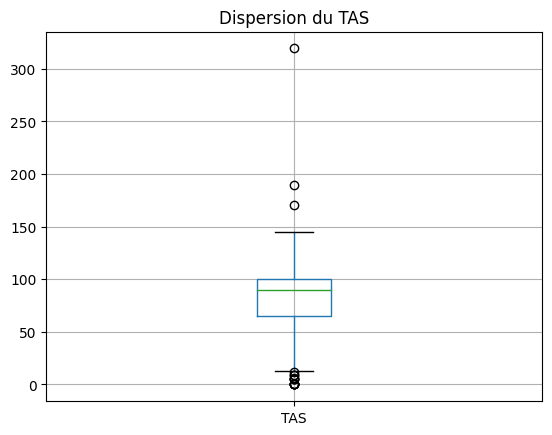

In [79]:
merged_df.boxplot(column="TAS", vert=True)
plt.title('Dispersion du TAS')
plt.show()

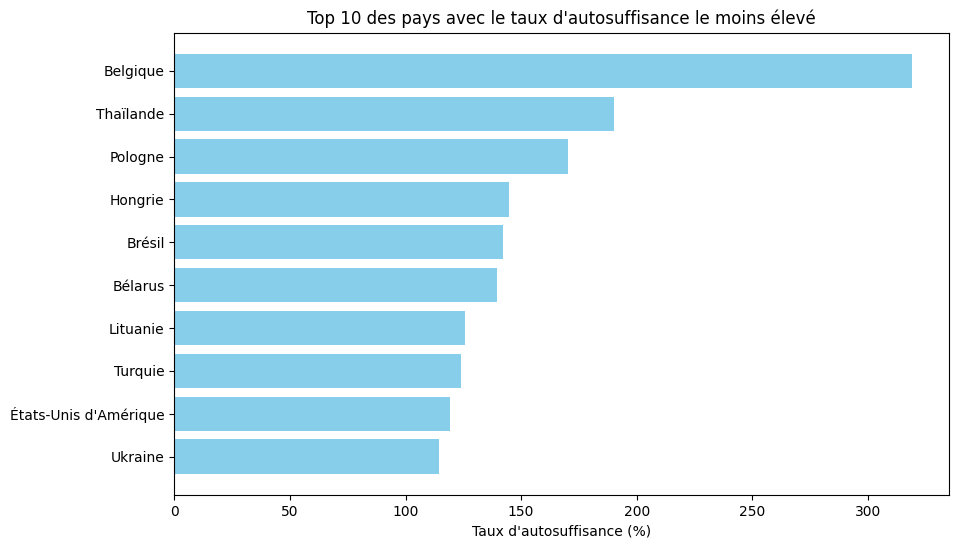

In [80]:
# Trier le DataFrame par le TAS dans l'ordre décroissant
sorted_df = merged_df.sort_values(by='TAS', ascending=False)

# Sélectionner les 10 premiers pays avec les taux d'autosuffisance les plus élevés
top_autosuffisance = sorted_df.head(10)

# Créer un graphique à barres pour représenter les taux d'autosuffisance les plus élevés
plt.figure(figsize=(10, 6))
plt.barh(top_autosuffisance.index, top_autosuffisance['TAS'], color='skyblue')
plt.xlabel('Taux d\'autosuffisance (%)')
plt.title('Top 10 des pays avec le taux d\'autosuffisance le moins élevé')
plt.gca().invert_yaxis()  # Inverser l'ordre des pays sur l'axe y pour avoir le pays avec le plus haut TAS en haut
plt.show()


 un TAS négatif indique généralement une dépendance aux importations pour répondre à la demande intérieure, et peut être le résultat de divers facteurs économiques et politiques.

### <font color="lightgreen">- TDI : TAUX DE DEPENDANCE DES IMPORTATIONS</font>

<font color='lightblue'>https://www.fao.org/3/x9892f/x9892f09.htm#TopOfPage


TAUX DE DÉPENDANCE DES IMPORTATIONS (TDI)

Au cours de l'analyse de la situation alimentaire d'un pays, il importe de bien savoir quelle part les approvisionnements intérieurs disponibles provient des importations et quelle part provient de la production du pays lui-même. Le TDI répond à cette question. Il se définit ainsi:

<font color='orange'>TDI= (Valeur de la production intèrieure/Valeur des importations) ×100
</font>

In [81]:
merged_df.head(1)

,Disponibilité en kg,Exportations en kg,Importation en kg,Production en kg,population_2017,proportion_ss_nutrition_2017,z_score,indice_stabilite_politique_2017,Valeur US $ par habitant,TAS
Zone,,,,,,,,,,
Afrique du Sud,2.118000e+09,63000000.0,514000000.0,1.667000e+09,57009756.0,5.44,-0.040644,-0.28,6723.928582,78.706327


In [82]:
# Calculer le taux de dépendance des importations (TDI)
merged_df['TDI'] = (merged_df['Importation en kg'] / (merged_df['Production en kg'] + merged_df['Importation en kg'])) * 100

In [83]:
merged_df['TDI'].describe()

count    117.000000
mean      30.709089
std       32.705469
min        0.000000
25%        3.794643
50%       18.510158
75%       50.232558
max      100.000000
Name: TDI, dtype: float64

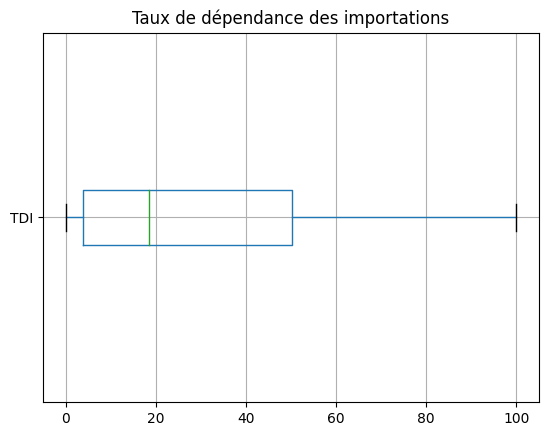

In [84]:
merged_df.boxplot(column="TDI", vert=False)
plt.title('Taux de dépendance des importations')
plt.show()

In [85]:
fig = px.scatter(merged_df, x=merged_df.index, y='TDI', hover_data=[merged_df.index])
fig.update_layout(title='Dispersion du TDI', xaxis_title='Index', yaxis_title='TDI')
fig.show()


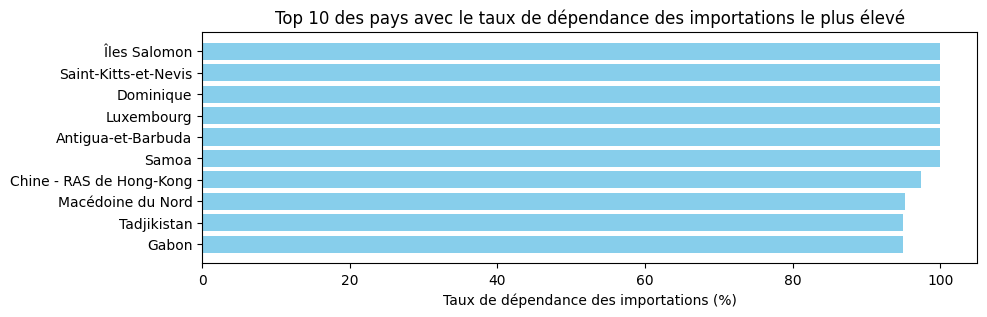

In [86]:
# Trier le DataFrame par le TDI dans l'ordre croissant
sorted_df_tdi = merged_df.sort_values(by='TDI', ascending=False)

# Sélectionner les 10 premiers pays avec les taux de dépendance des importations les moins élevés
lowest_tdi = sorted_df_tdi.head(10)

# Créer un graphique à barres pour représenter les taux de dépendance des importations les moins élevés
plt.figure(figsize=(10, 3))
plt.barh(lowest_tdi.index, lowest_tdi['TDI'], color='skyblue')
plt.xlabel('Taux de dépendance des importations (%)')
plt.title('Top 10 des pays avec le taux de dépendance des importations le plus élevé')
plt.gca().invert_yaxis() 
plt.show()

==============================================================

### <font color="lightgreen">- Consommation moyenne en kg de poulet par habitant et par an.</font>

((importations + productions) - exportations)/ populations

                      Consommation_moyenne_poulet_en_kg
Zone                                                   
Samoa                                         87.022401
Saint-Kitts-et-Nevis                          76.856566
Israël                                        75.935413
Antigua-et-Barbuda                            73.355270
Sainte-Lucie                                  60.780530


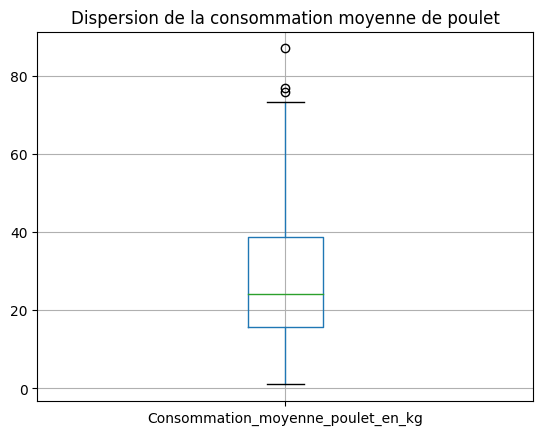

In [87]:
# Calcul de la consommation moyenne de poulet par habitant et par an
merged_df['Consommation_moyenne_poulet_en_kg'] = (merged_df['Importation en kg'] + merged_df['Production en kg'] - merged_df['Exportations en kg']) / merged_df['population_2017']

# Afficher la consommation moyenne de poulet par pays
consommation_moyenne_poulet_par_pays = merged_df[['Consommation_moyenne_poulet_en_kg']]

# tri sur la consommation de poulet la plus élevée
print(consommation_moyenne_poulet_par_pays.sort_values(by='Consommation_moyenne_poulet_en_kg', ascending=False).head(5))

merged_df.boxplot(column="Consommation_moyenne_poulet_en_kg", vert=True)
plt.title('Dispersion de la consommation moyenne de poulet')
plt.show()

In [88]:
fig = px.scatter(merged_df, x=merged_df.index, y='Consommation_moyenne_poulet_en_kg', hover_data=[merged_df.index])
fig.update_layout(title='Dispersion de la Consommation_moyenne_poulet_en_kg', xaxis_title='Index', yaxis_title='Consommation')
fig.show()

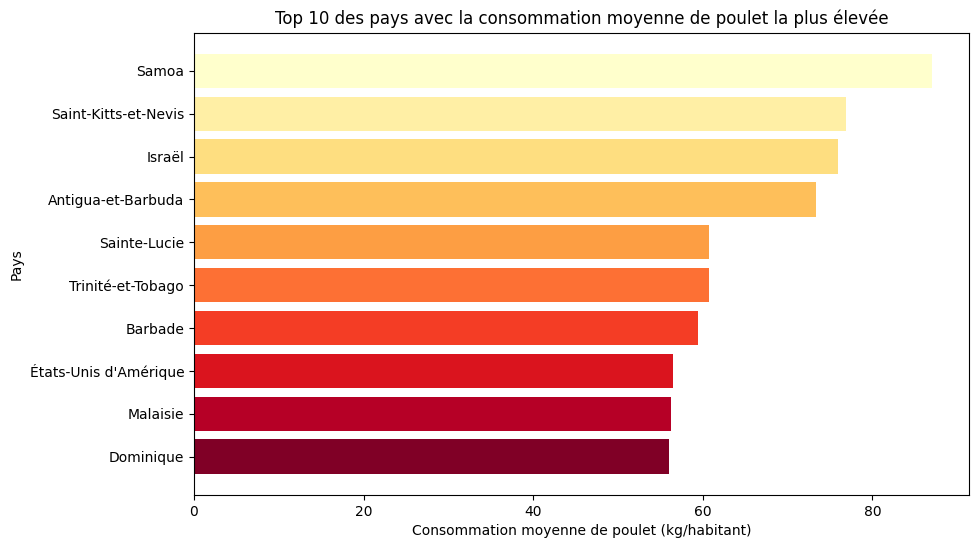

In [89]:
# Tri des données
top_10_consommation = consommation_moyenne_poulet_par_pays.sort_values(by='Consommation_moyenne_poulet_en_kg', ascending=False).head(10)

# Création de la palette de couleurs chaude
colors = plt.cm.YlOrRd(np.linspace(0, 1, 10))  # Palette de couleurs allant du jaune à l'orange foncé

# Création du graphique à barres horizontales avec une palette de couleurs chaude
plt.figure(figsize=(10, 6))
bars = plt.barh(top_10_consommation.index, top_10_consommation['Consommation_moyenne_poulet_en_kg'], color=colors)
plt.xlabel('Consommation moyenne de poulet (kg/habitant)')
plt.ylabel('Pays')
plt.title('Top 10 des pays avec la consommation moyenne de poulet la plus élevée')

plt.gca().invert_yaxis()  # Inversion de l'axe y pour avoir le pays avec la plus grande consommation en haut
plt.show()


In [90]:
merged_df = merged_df.drop(columns='z_score')

### <font color='pink'>5. Analyse univariée et bivariée</font>

### <font color='orange'>Description des données</font>

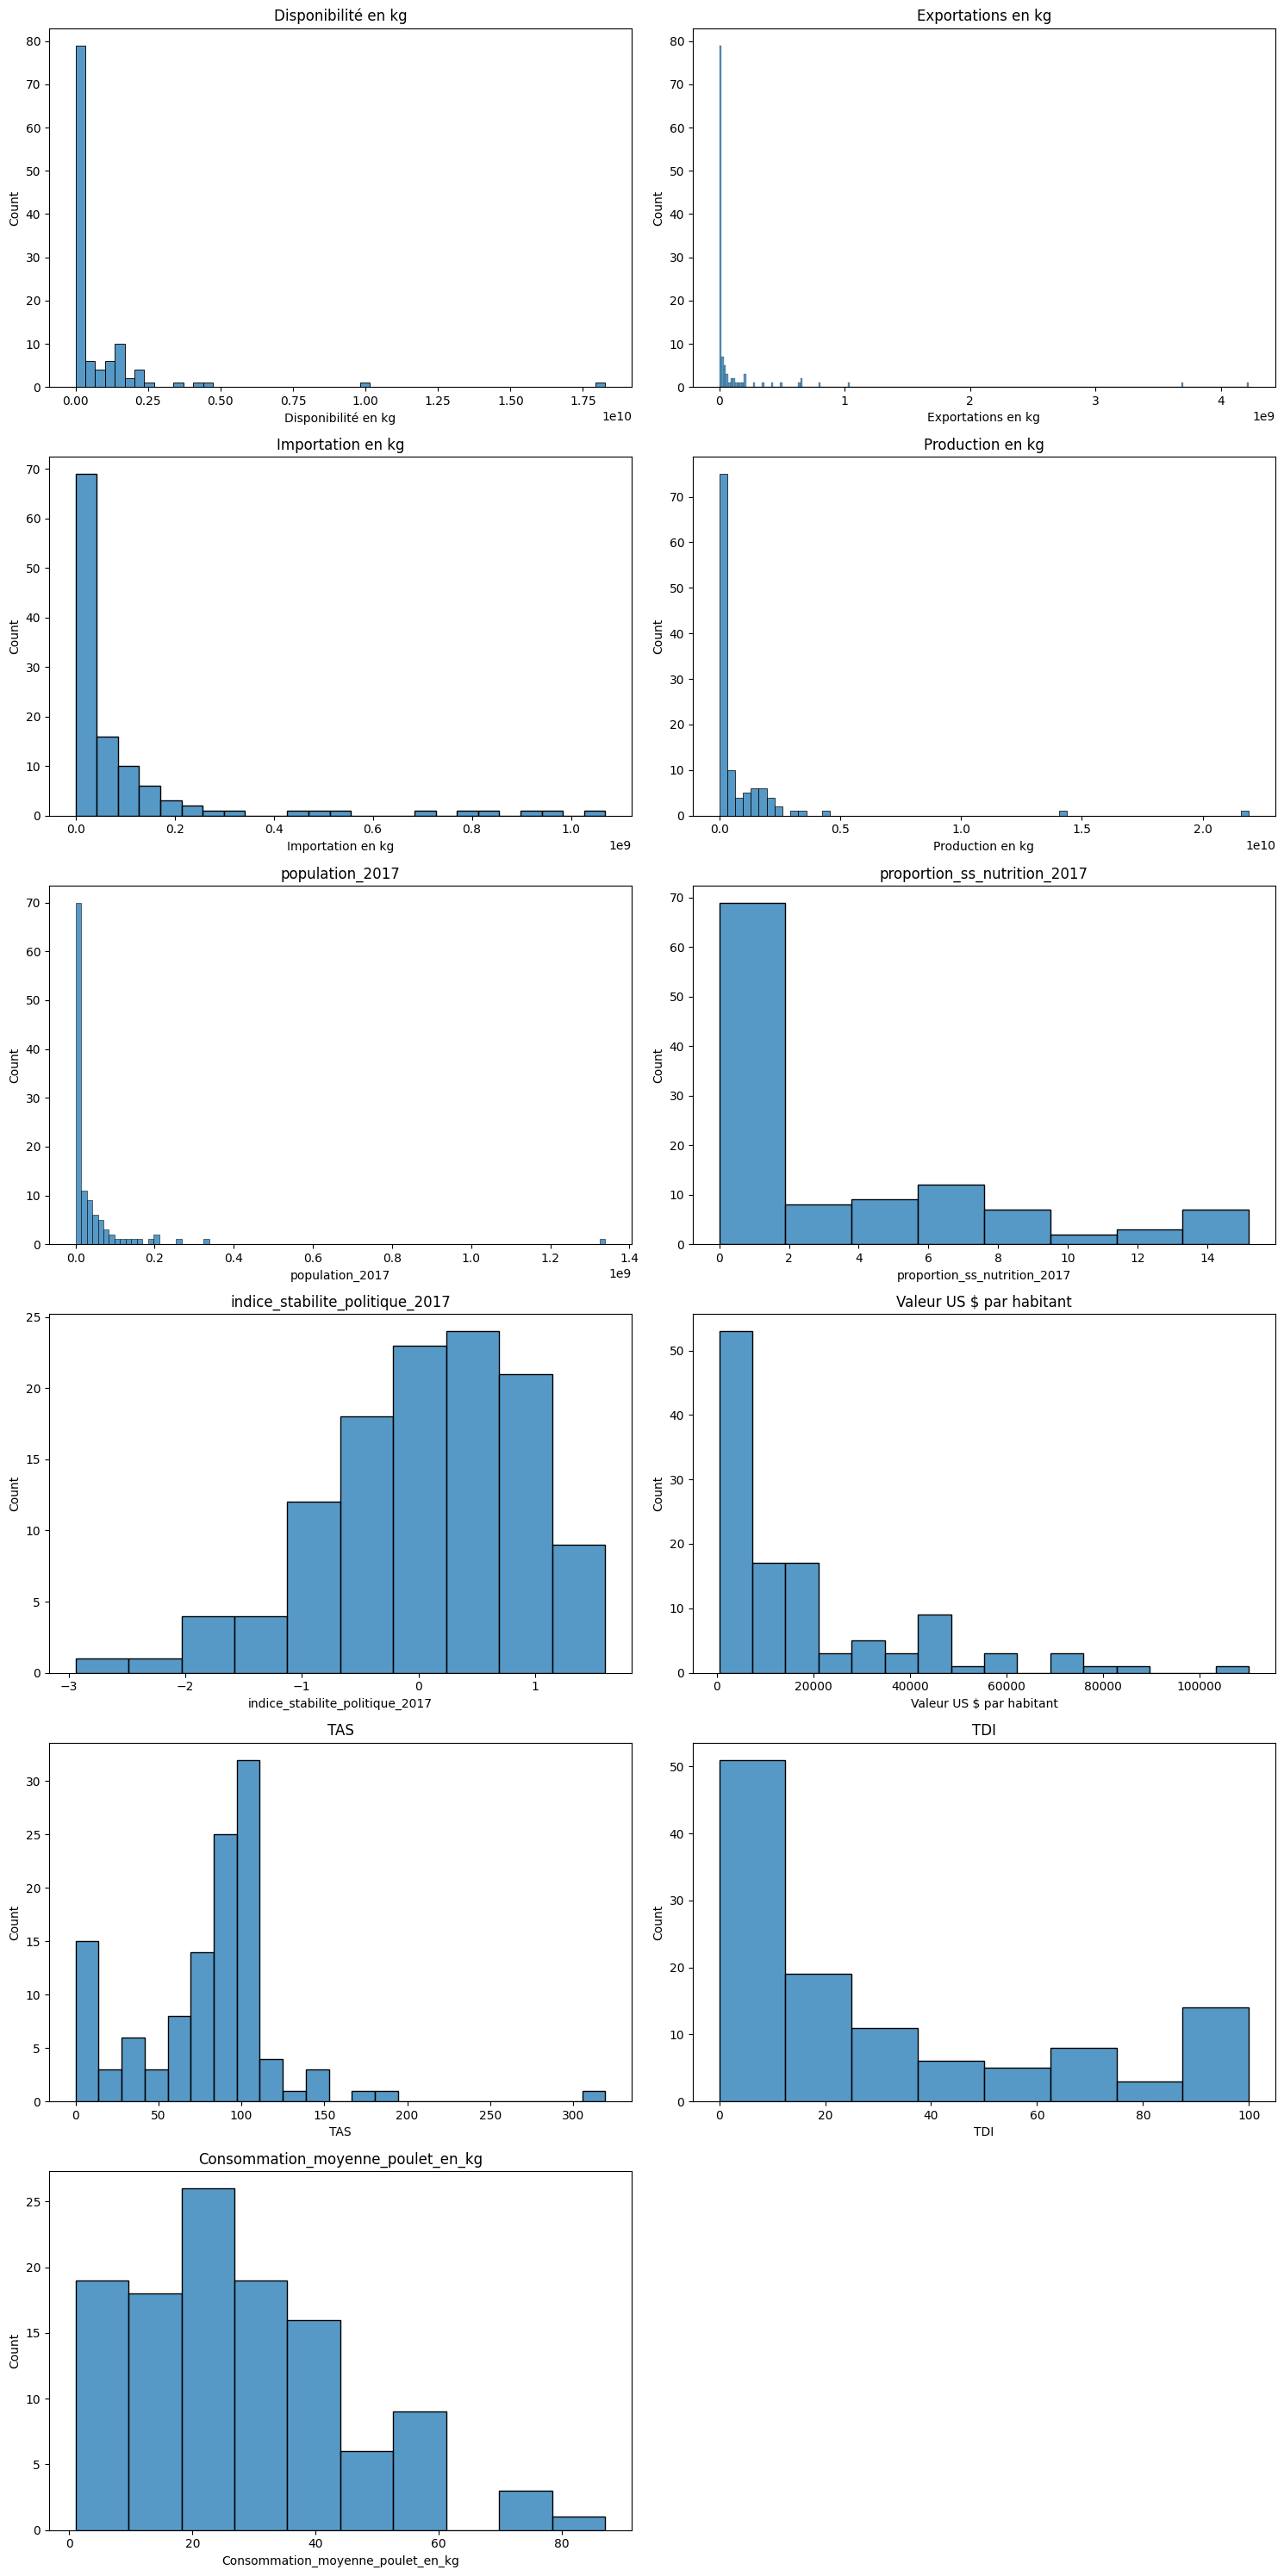

In [91]:
num_cols = len(merged_df.columns)
num_rows = num_cols // 2 if num_cols % 2 == 0 else num_cols // 2 + 1

plt.figure(figsize=(15, num_rows*5))
for i, column in enumerate(merged_df.columns, start=1):  # Démarre l'énumération à partir de 1
    plt.subplot(num_rows, 2, i)
    sns.histplot(merged_df[column].dropna())  # Trace l'histogramme pour chaque colonne
    plt.title(column)
plt.tight_layout()
plt.show()


Disponibilité en kg


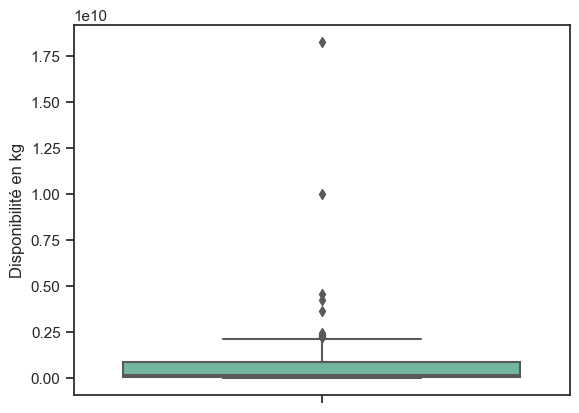

Exportations en kg


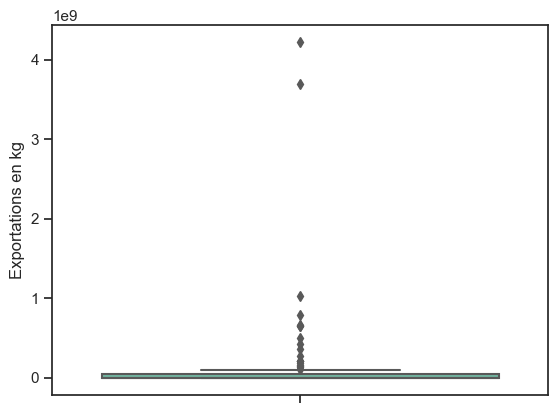

Importation en kg


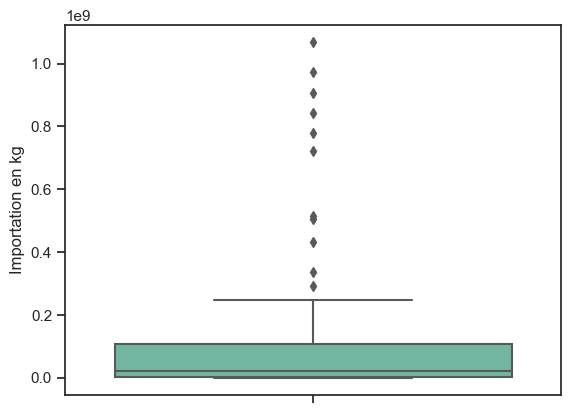

Production en kg


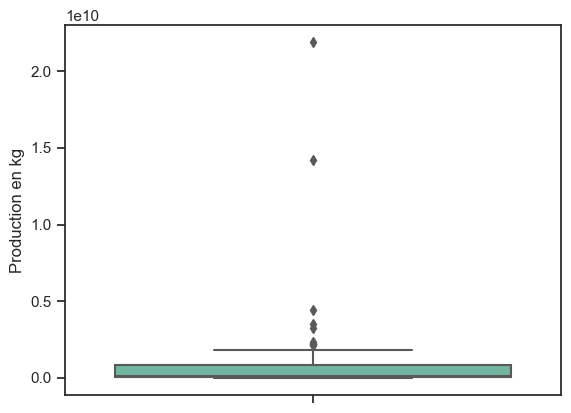

population_2017


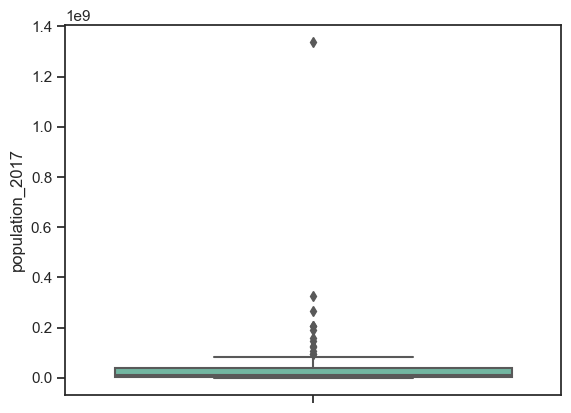

proportion_ss_nutrition_2017


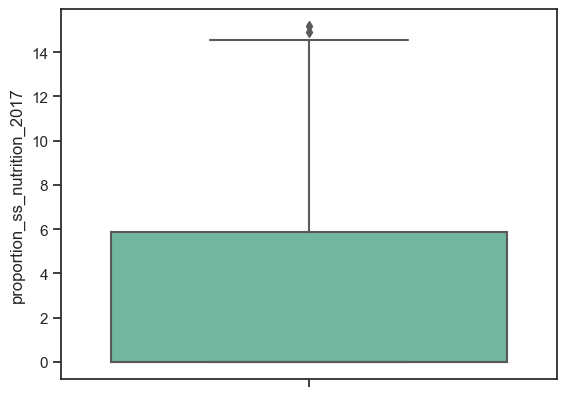

indice_stabilite_politique_2017


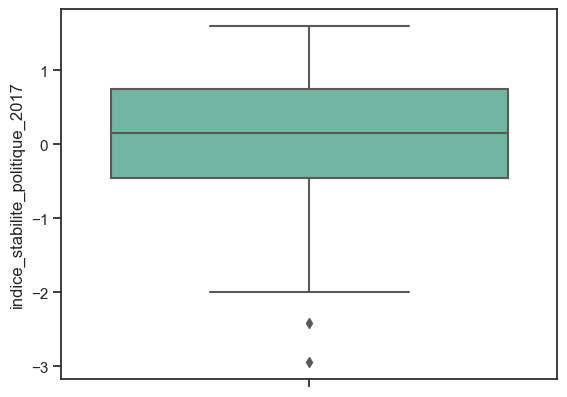

Valeur US $ par habitant


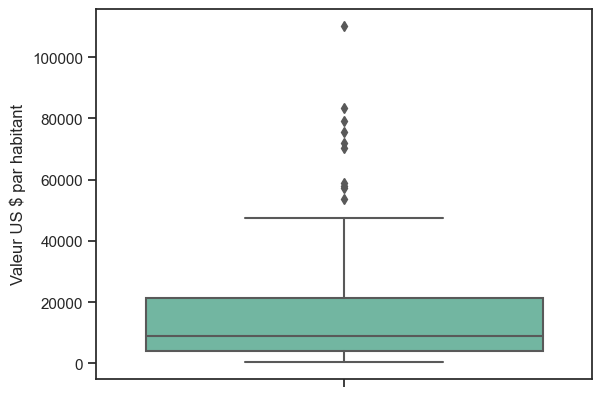

TAS


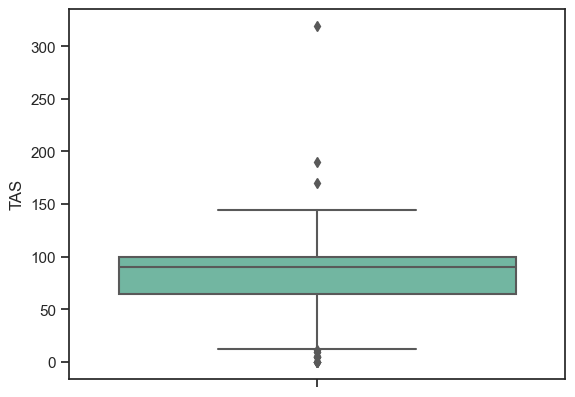

TDI


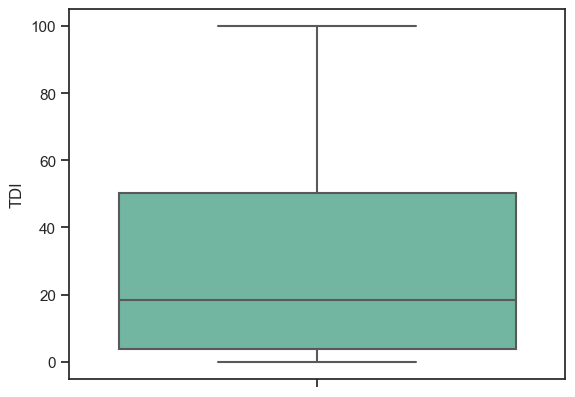

Consommation_moyenne_poulet_en_kg


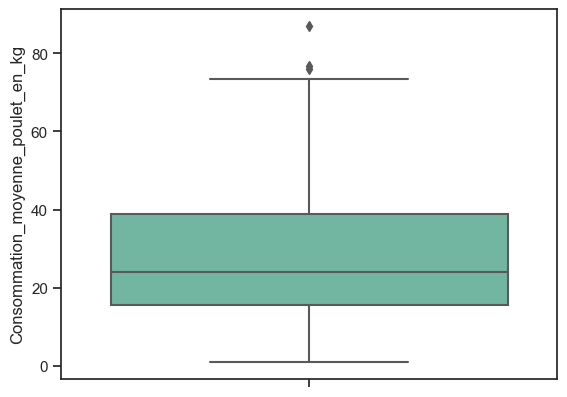

In [92]:
# Analyse descriptive des variables quantitatives
# Sélection des variables quantitatives
quant_vars = merged_df.select_dtypes(include=['float64', 'int64'])

# Tracé des boxplots pour chaque variable quantitative avec Seaborn
sns.set(style="ticks")
for var in quant_vars:
    print(var)
    sns.boxplot(y=var, data=quant_vars, palette="Set2")
    plt.show()

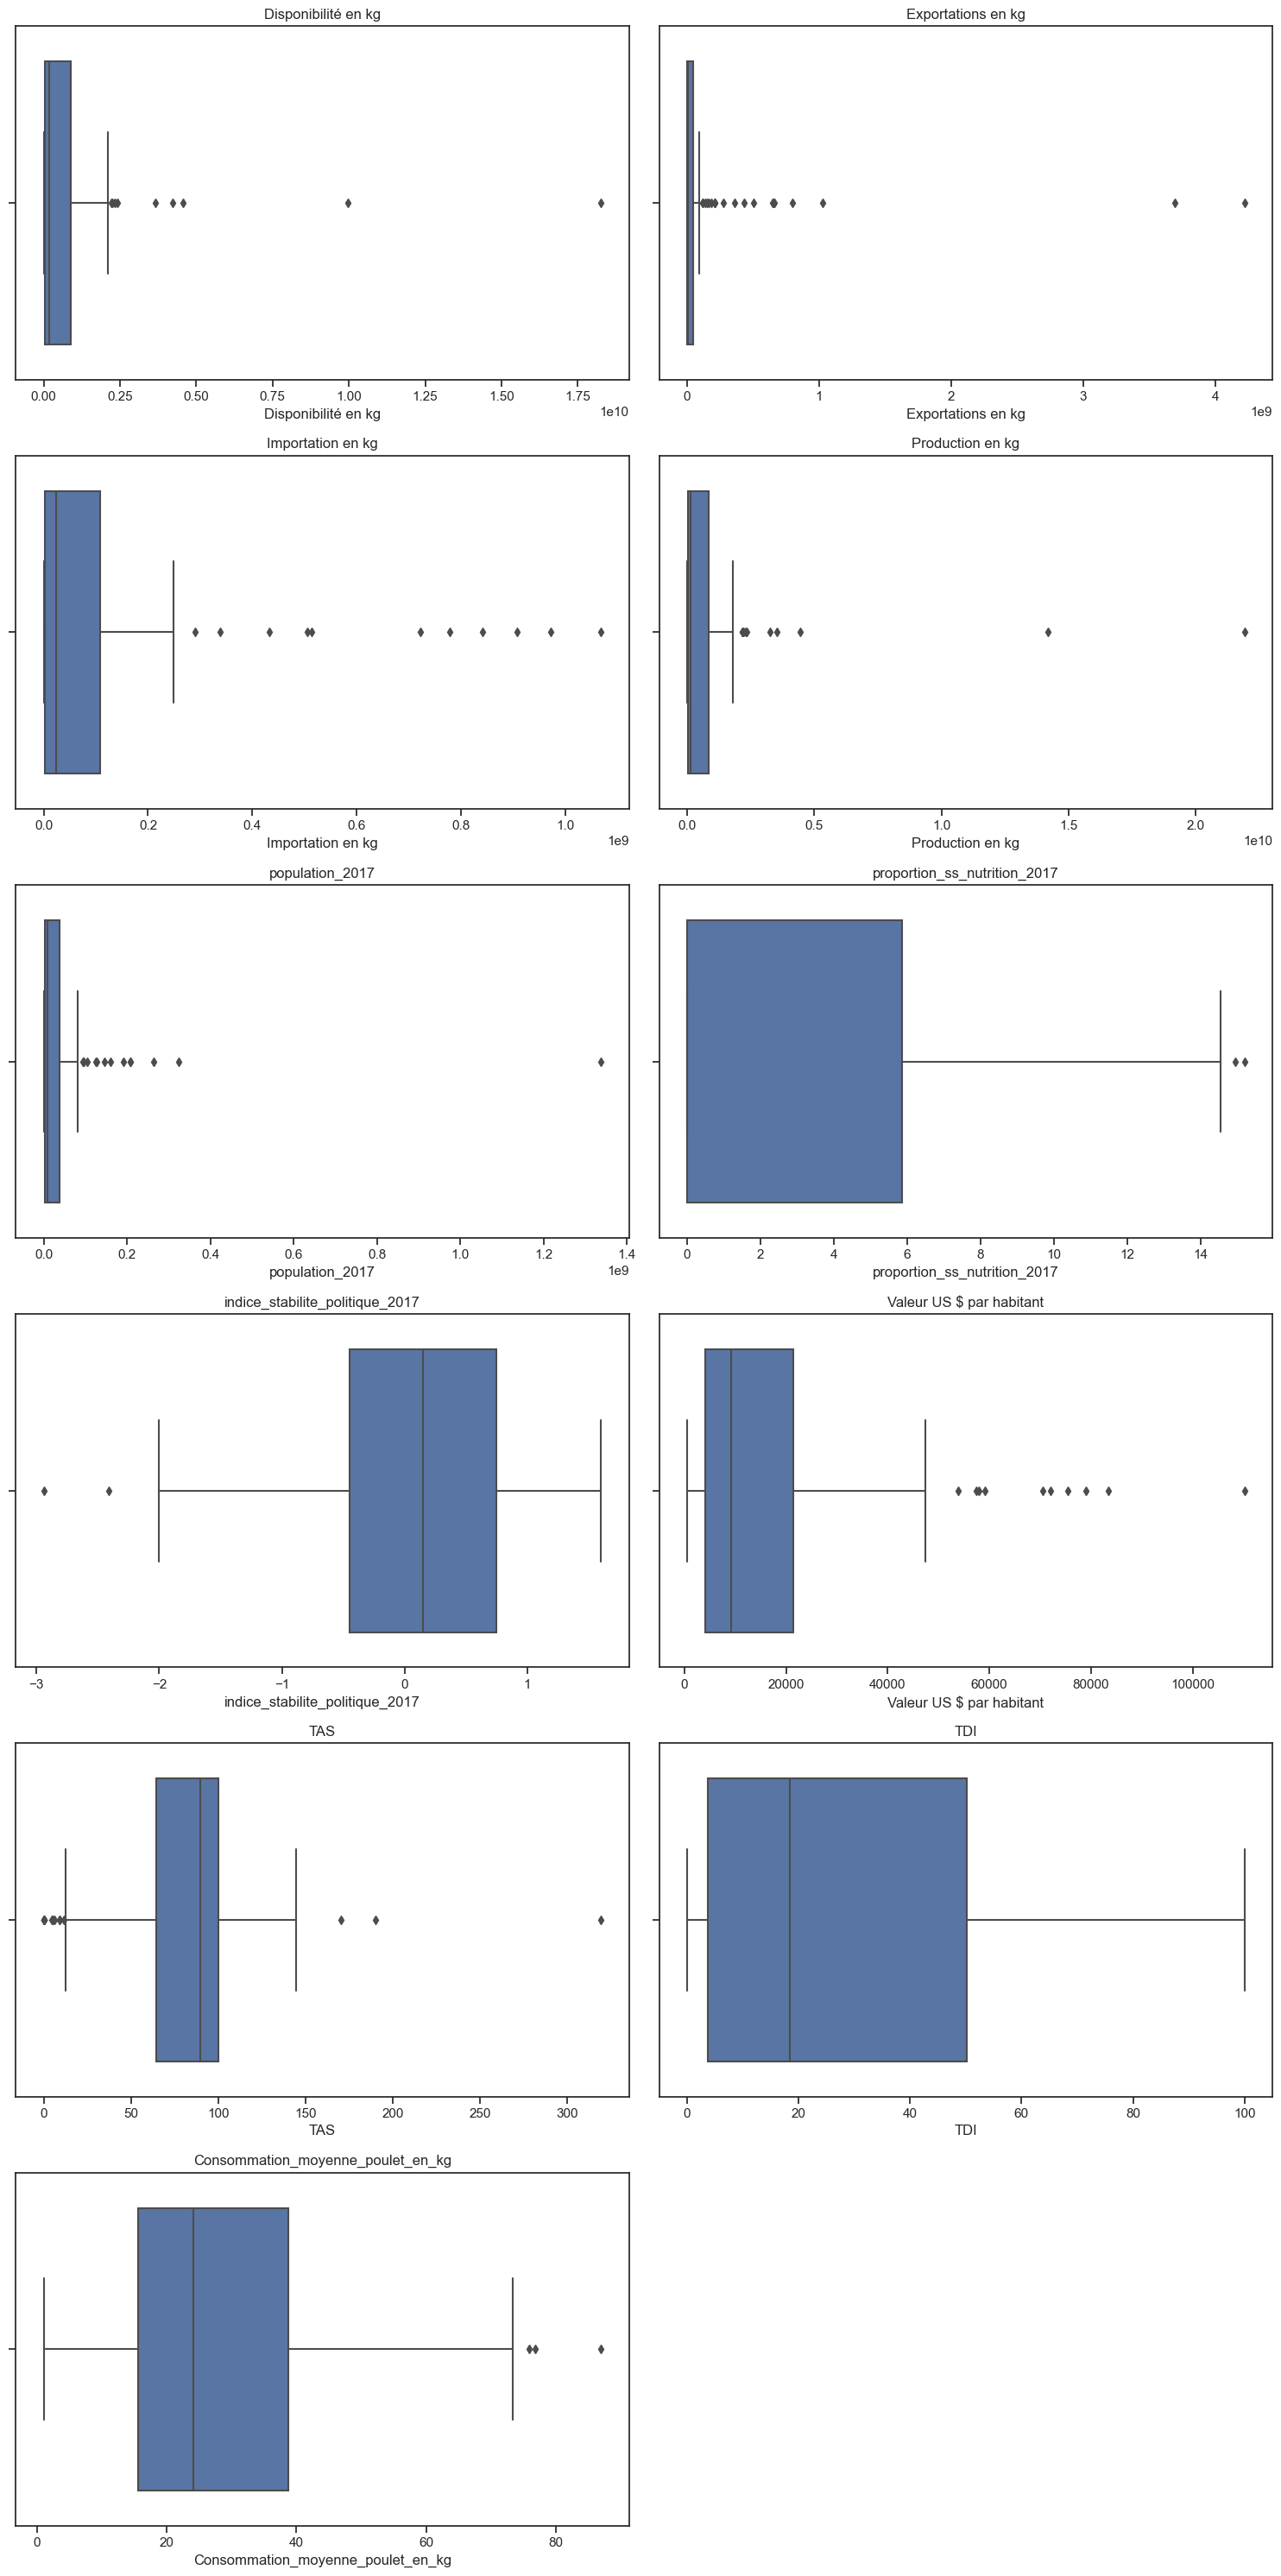

In [93]:
# Sélectionner uniquement les colonnes numériques
numeric_cols = merged_df.select_dtypes(include=['float64', 'int64'])

# Calculer le nombre de lignes et de colonnes pour le sous-graphique
num_cols = len(numeric_cols.columns)
num_rows = num_cols // 2 if num_cols % 2 == 0 else num_cols // 2 + 1

# Créer le sous-graphique
plt.figure(figsize=(15, num_rows*5))
for i, column in enumerate(numeric_cols.columns, start=1):  # Démarre l'énumération à partir de 1
    plt.subplot(num_rows, 2, i)
    sns.boxplot(x=merged_df[column])  # Trace le boxplot pour chaque colonne
    plt.title(column)
plt.tight_layout()
plt.show()


### <font color='orange'>Test de normalité : Shapiro-wilk</font>

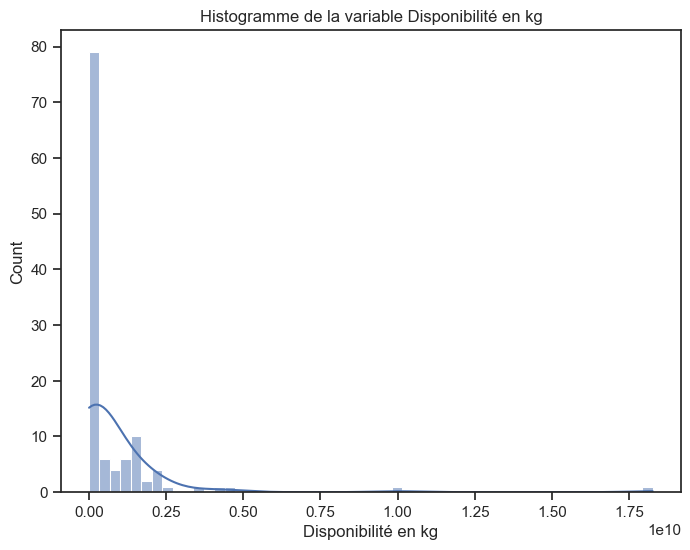

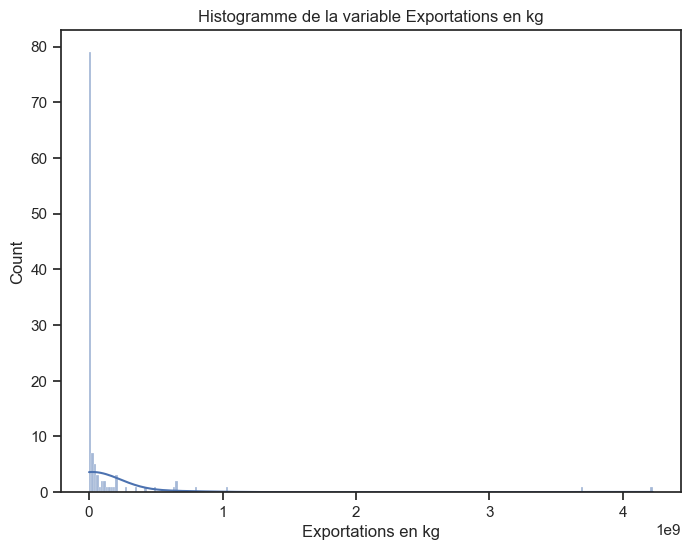

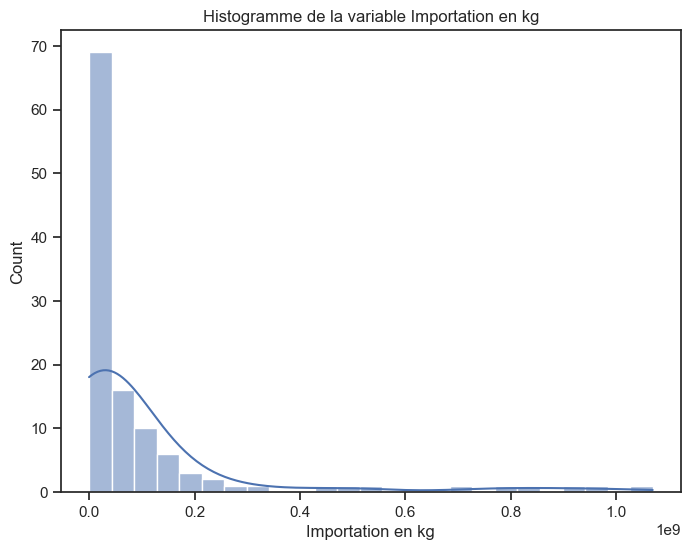

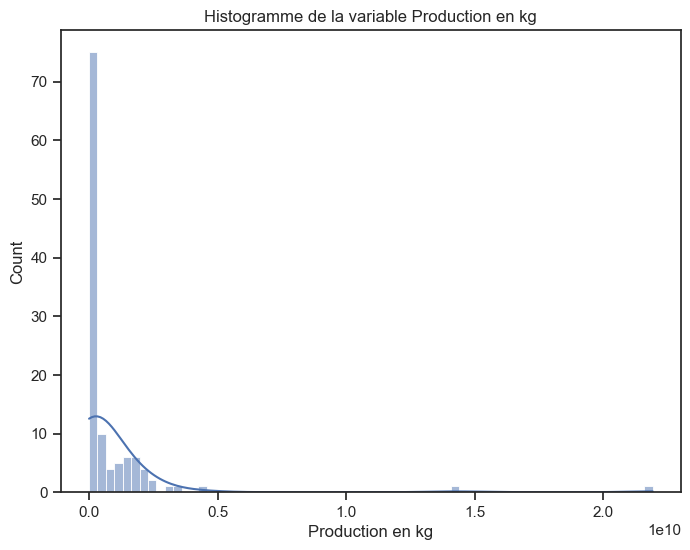

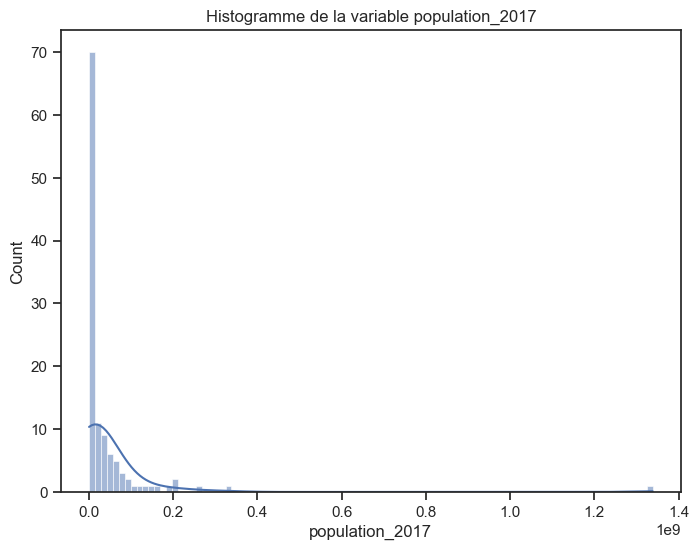

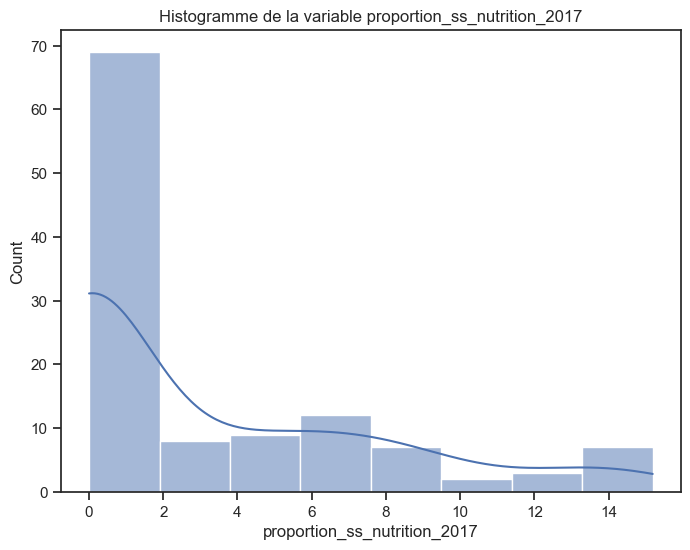

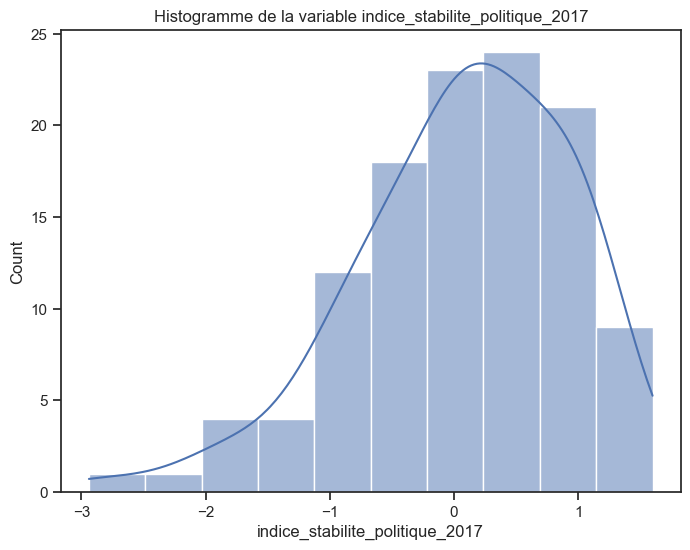

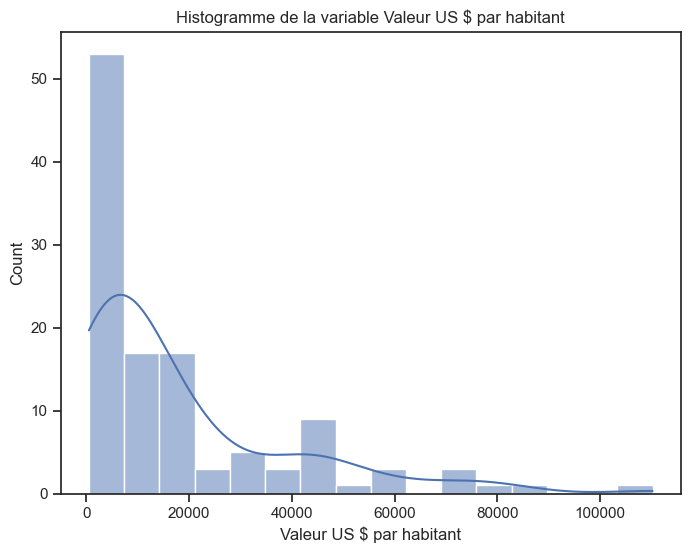

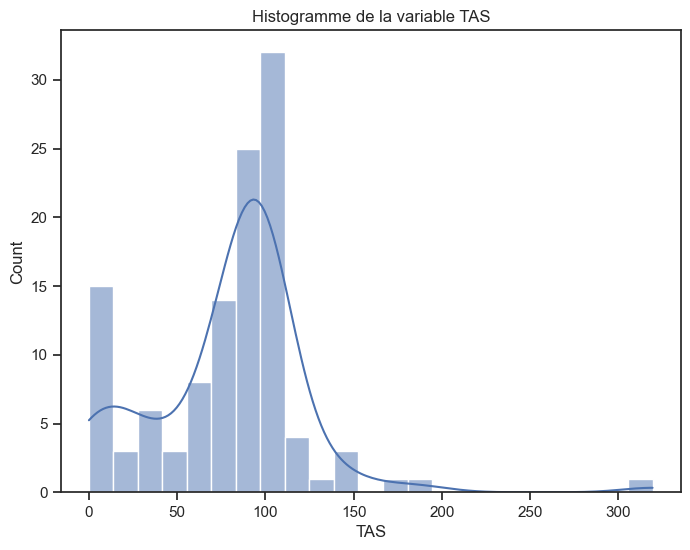

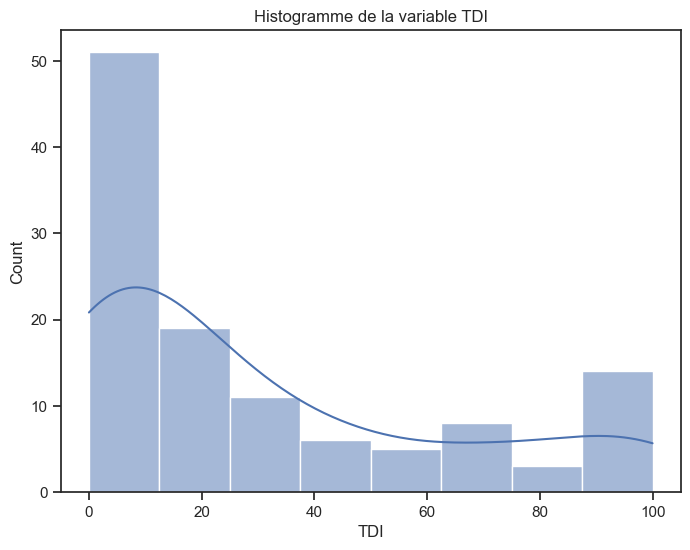

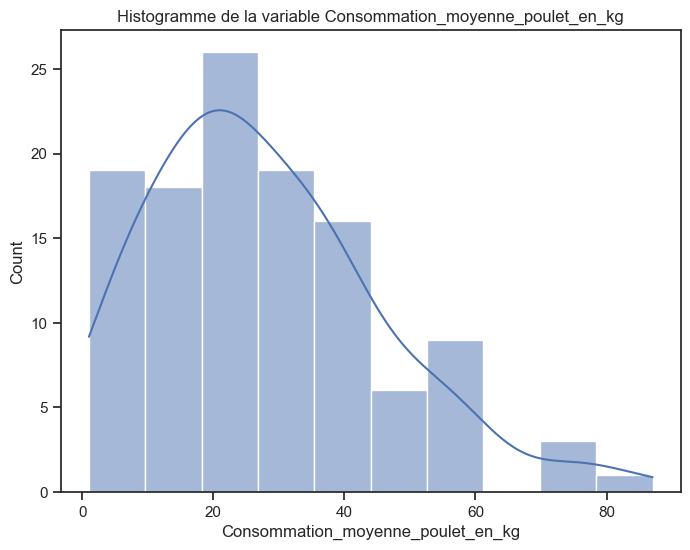

In [94]:
# Analyse de la normalité
from scipy.stats import shapiro

# Création d'un histogramme et d'un test de normalité pour chaque variable
for column in quant_vars:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=merged_df, x=column, kde=True)
    plt.title(f"Histogramme de la variable {column}")
    plt.show()

##### <font color='orange'>Test de normalité des données : Shapiro-Wilk</font>

In [95]:
# Initialisation d'une liste pour stocker les résultats des tests de normalité
normality_results = []

# Boucle pour calculer les tests de normalité pour chaque variable
for var in quant_vars:
    stat, p = shapiro(quant_vars[var])
    normality = 'Normal' if p > 0.05 else 'Not Normal'
    normality_results.append({'Variable': var, 'P-value': p, 'Normality': normality})

# Création d'un DataFrame à partir de la liste des résultats des tests de normalité
normality_df = pd.DataFrame(normality_results)

# Affichage du DataFrame des résultats des tests de normalité
print(normality_df)


                             Variable       P-value   Normality
0                 Disponibilité en kg  3.442656e-20  Not Normal
1                  Exportations en kg  9.502130e-22  Not Normal
2                   Importation en kg  1.141108e-17  Not Normal
3                    Production en kg  6.759321e-21  Not Normal
4                     population_2017  2.653477e-21  Not Normal
5        proportion_ss_nutrition_2017  3.031476e-13  Not Normal
6     indice_stabilite_politique_2017  1.758555e-03  Not Normal
7            Valeur US $ par habitant  1.502772e-12  Not Normal
8                                 TAS  1.529867e-09  Not Normal
9                                 TDI  3.047958e-10  Not Normal
10  Consommation_moyenne_poulet_en_kg  2.679014e-04  Not Normal


### <font color='orange'>Analyse bivariée</font>

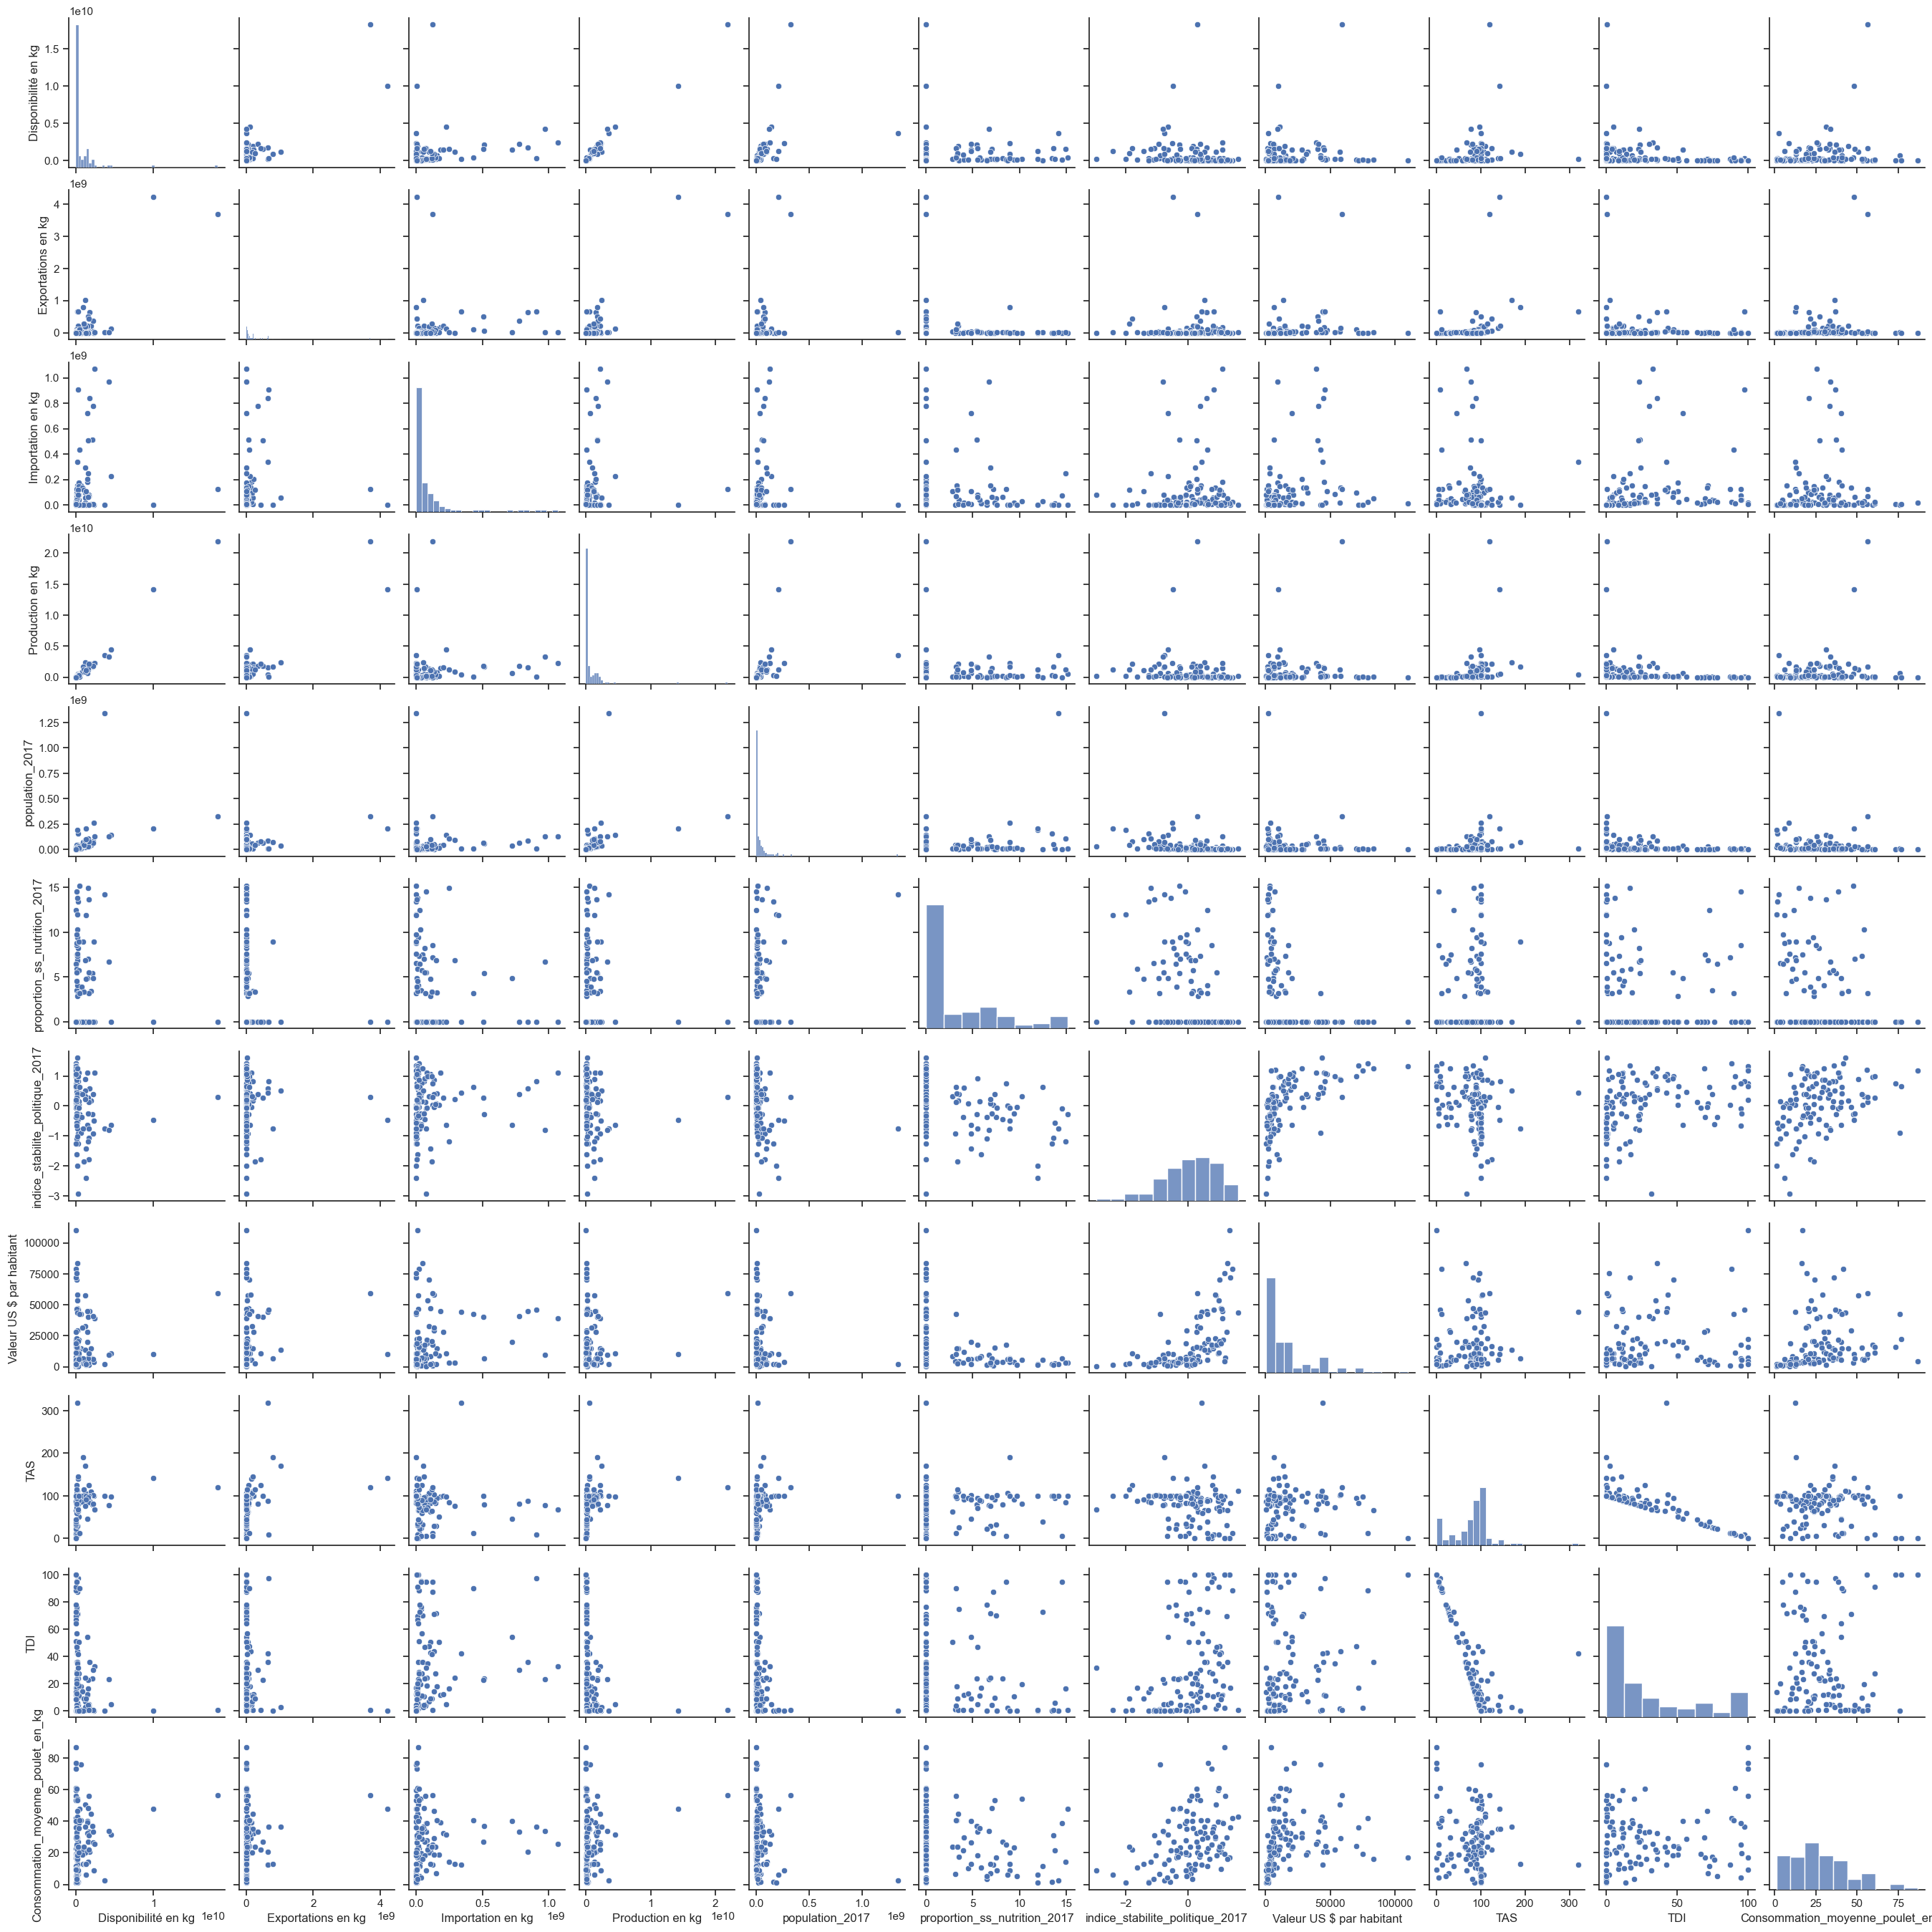

In [96]:
sns.pairplot(merged_df)
plt.show()

### <font color='orange'>Coeff. de corrélations de rang de Spearman</font>

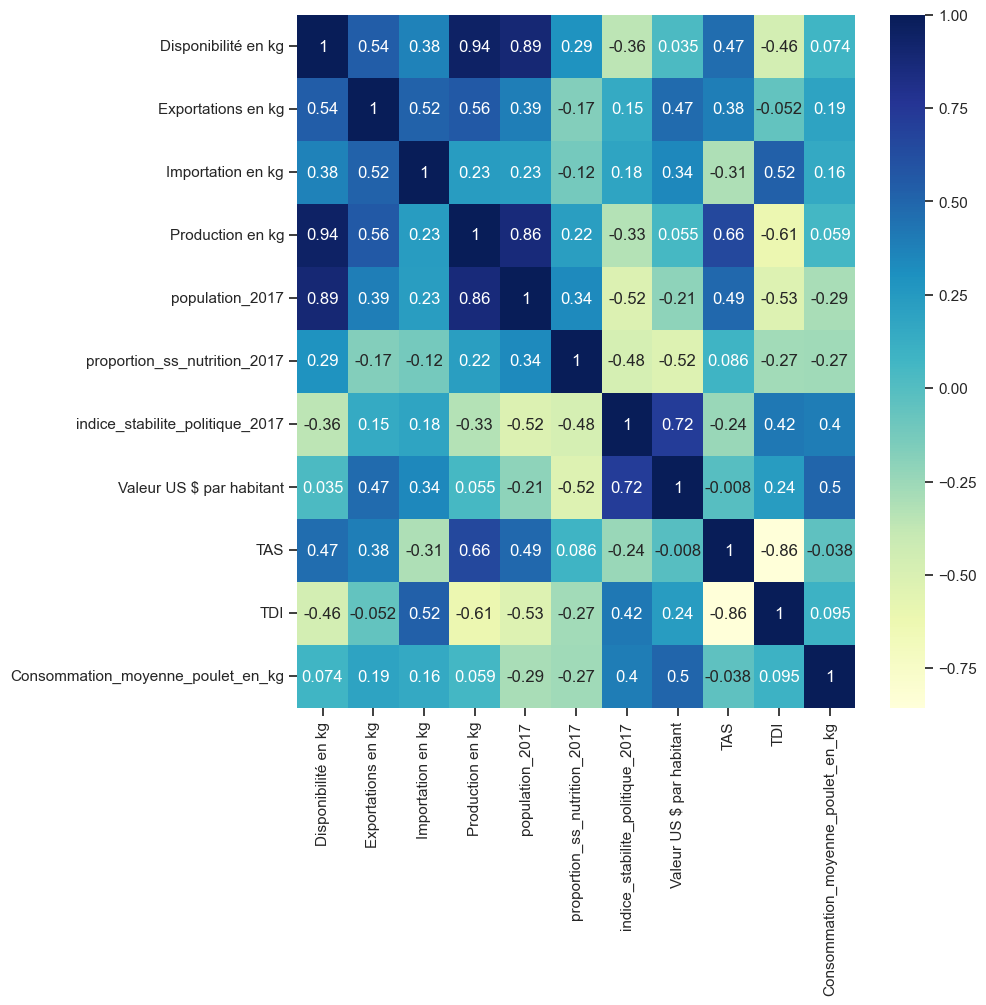

In [97]:
# Obtenir le tableau de corrélations et la heatmap (corrélation de spearman)

corr_matrix = merged_df.corr(method='spearman')

# Calcul des p-values pour chaque paire de variables
fig, ax = plt.subplots(figsize=(9,9))
sns.heatmap(corr_matrix,annot=True,cmap="YlGnBu")
plt.show()

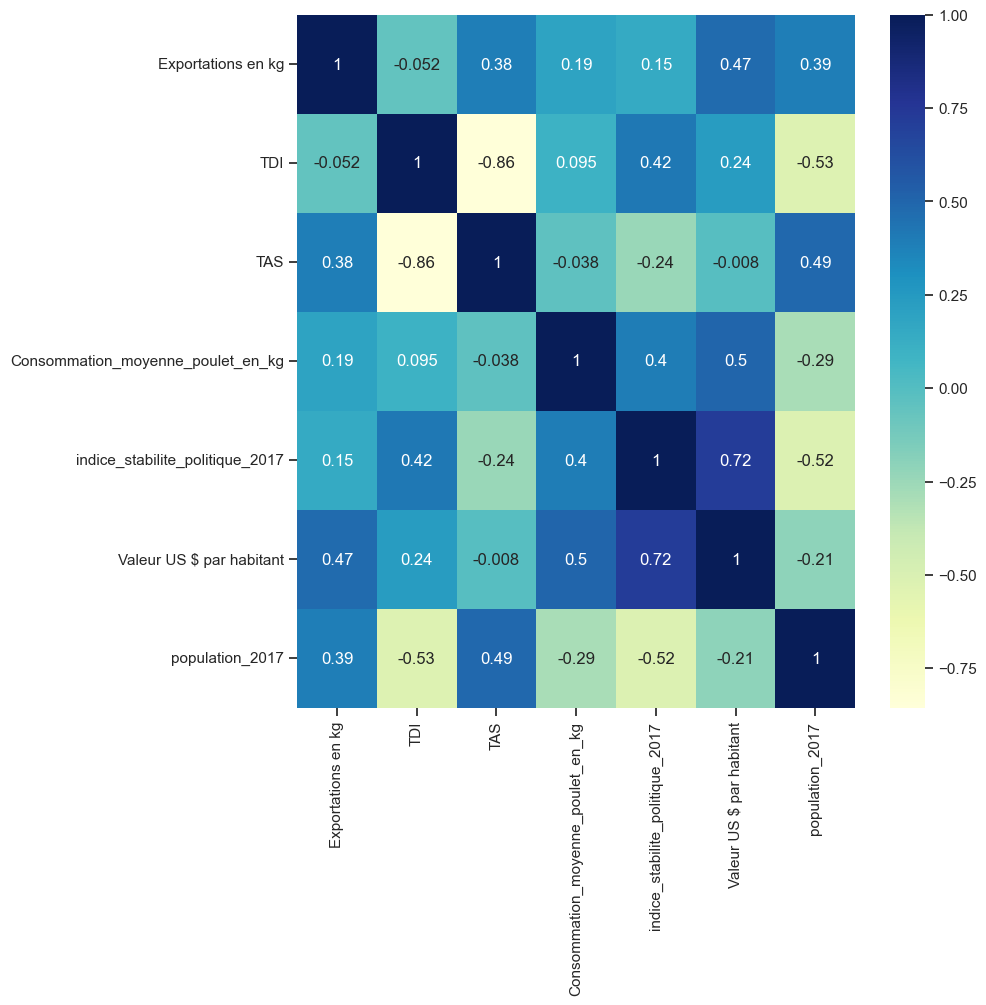

In [98]:
# Sélectionner les colonnes spécifiées
selected_columns = ['Exportations en kg','TDI', 'TAS', 'Consommation_moyenne_poulet_en_kg', 'indice_stabilite_politique_2017','Valeur US $ par habitant','population_2017']
selected_corr_matrix = merged_df[selected_columns].corr(method='spearman')

# Tracer la heatmap
fig, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(selected_corr_matrix, annot=True, cmap="YlGnBu")
plt.show()


In [99]:
# sélection des variables numériques
df_numeric = merged_df.select_dtypes(include=[np.number])

# Calculer le coefficient de corrélation spearman
correlation_spearman = df_numeric.corr(method='spearman').round(2)

# Afficher le résultat
correlation_spearman

,Disponibilité en kg,Exportations en kg,Importation en kg,Production en kg,population_2017,proportion_ss_nutrition_2017,indice_stabilite_politique_2017,Valeur US $ par habitant,TAS,TDI,Consommation_moyenne_poulet_en_kg
Disponibilité en kg,1.00,0.54,0.38,0.94,0.89,0.29,-0.36,0.03,0.47,-0.46,0.07
Exportations en kg,0.54,1.00,0.52,0.56,0.39,-0.17,0.15,0.47,0.38,-0.05,0.19
Importation en kg,0.38,0.52,1.00,0.23,0.23,-0.12,0.18,0.34,-0.31,0.52,0.16
Production en kg,0.94,0.56,0.23,1.00,0.86,0.22,-0.33,0.06,0.66,-0.61,0.06
population_2017,0.89,0.39,0.23,0.86,1.00,0.34,-0.52,-0.21,0.49,-0.53,-0.29
proportion_ss_nutrition_2017,0.29,-0.17,-0.12,0.22,0.34,1.00,-0.48,-0.52,0.09,-0.27,-0.27
indice_stabilite_politique_2017,-0.36,0.15,0.18,-0.33,-0.52,-0.48,1.00,0.72,-0.24,0.42,0.40
Valeur US $ par habitant,0.03,0.47,0.34,0.06,-0.21,-0.52,0.72,1.00,-0.01,0.24,0.50
TAS,0.47,0.38,-0.31,0.66,0.49,0.09,-0.24,-0.01,1.00,-0.86,-0.04
TDI,-0.46,-0.05,0.52,-0.61,-0.53,-0.27,0.42,0.24,-0.86,1.00,0.09


### <font color='pink'>6. Sélection de nos features</font>

In [100]:
# Sélectionner uniquement les colonnes spécifiées
new_merged_df = merged_df[["Exportations en kg","population_2017", "indice_stabilite_politique_2017", "Valeur US $ par habitant", 'TAS', 'TDI', 'Consommation_moyenne_poulet_en_kg']]

# Afficher le DataFrame mis à jour
new_merged_df.head()
print(new_merged_df.shape)


(117, 7)


### <font color='pink'>7. Détection des anomalies avec IsolationForest</font>

### <font color='orange'>Analyse des Outliers</font>

In [101]:
new_merged_df.describe().round(2)

,Exportations en kg,population_2017,indice_stabilite_politique_2017,Valeur US $ par habitant,TAS,TDI,Consommation_moyenne_poulet_en_kg
count,1.170000e+02,1.170000e+02,117.00,117.00,117.00,117.00,117.00
mean,1.353504e+08,4.379285e+07,0.07,18131.10,79.55,30.71,27.80
std,5.353487e+08,1.328422e+08,0.87,21262.91,44.36,32.71,17.82
min,0.000000e+00,5.204500e+04,-2.94,514.54,0.00,0.00,1.02
25%,0.000000e+00,3.351525e+06,-0.45,4057.62,64.68,3.79,15.62
50%,4.000000e+06,9.729823e+06,0.15,9107.70,89.71,18.51,24.13
75%,4.400000e+07,3.795318e+07,0.75,21475.36,100.00,50.23,38.74
max,4.223000e+09,1.338677e+09,1.60,110203.01,319.31,100.00,87.02


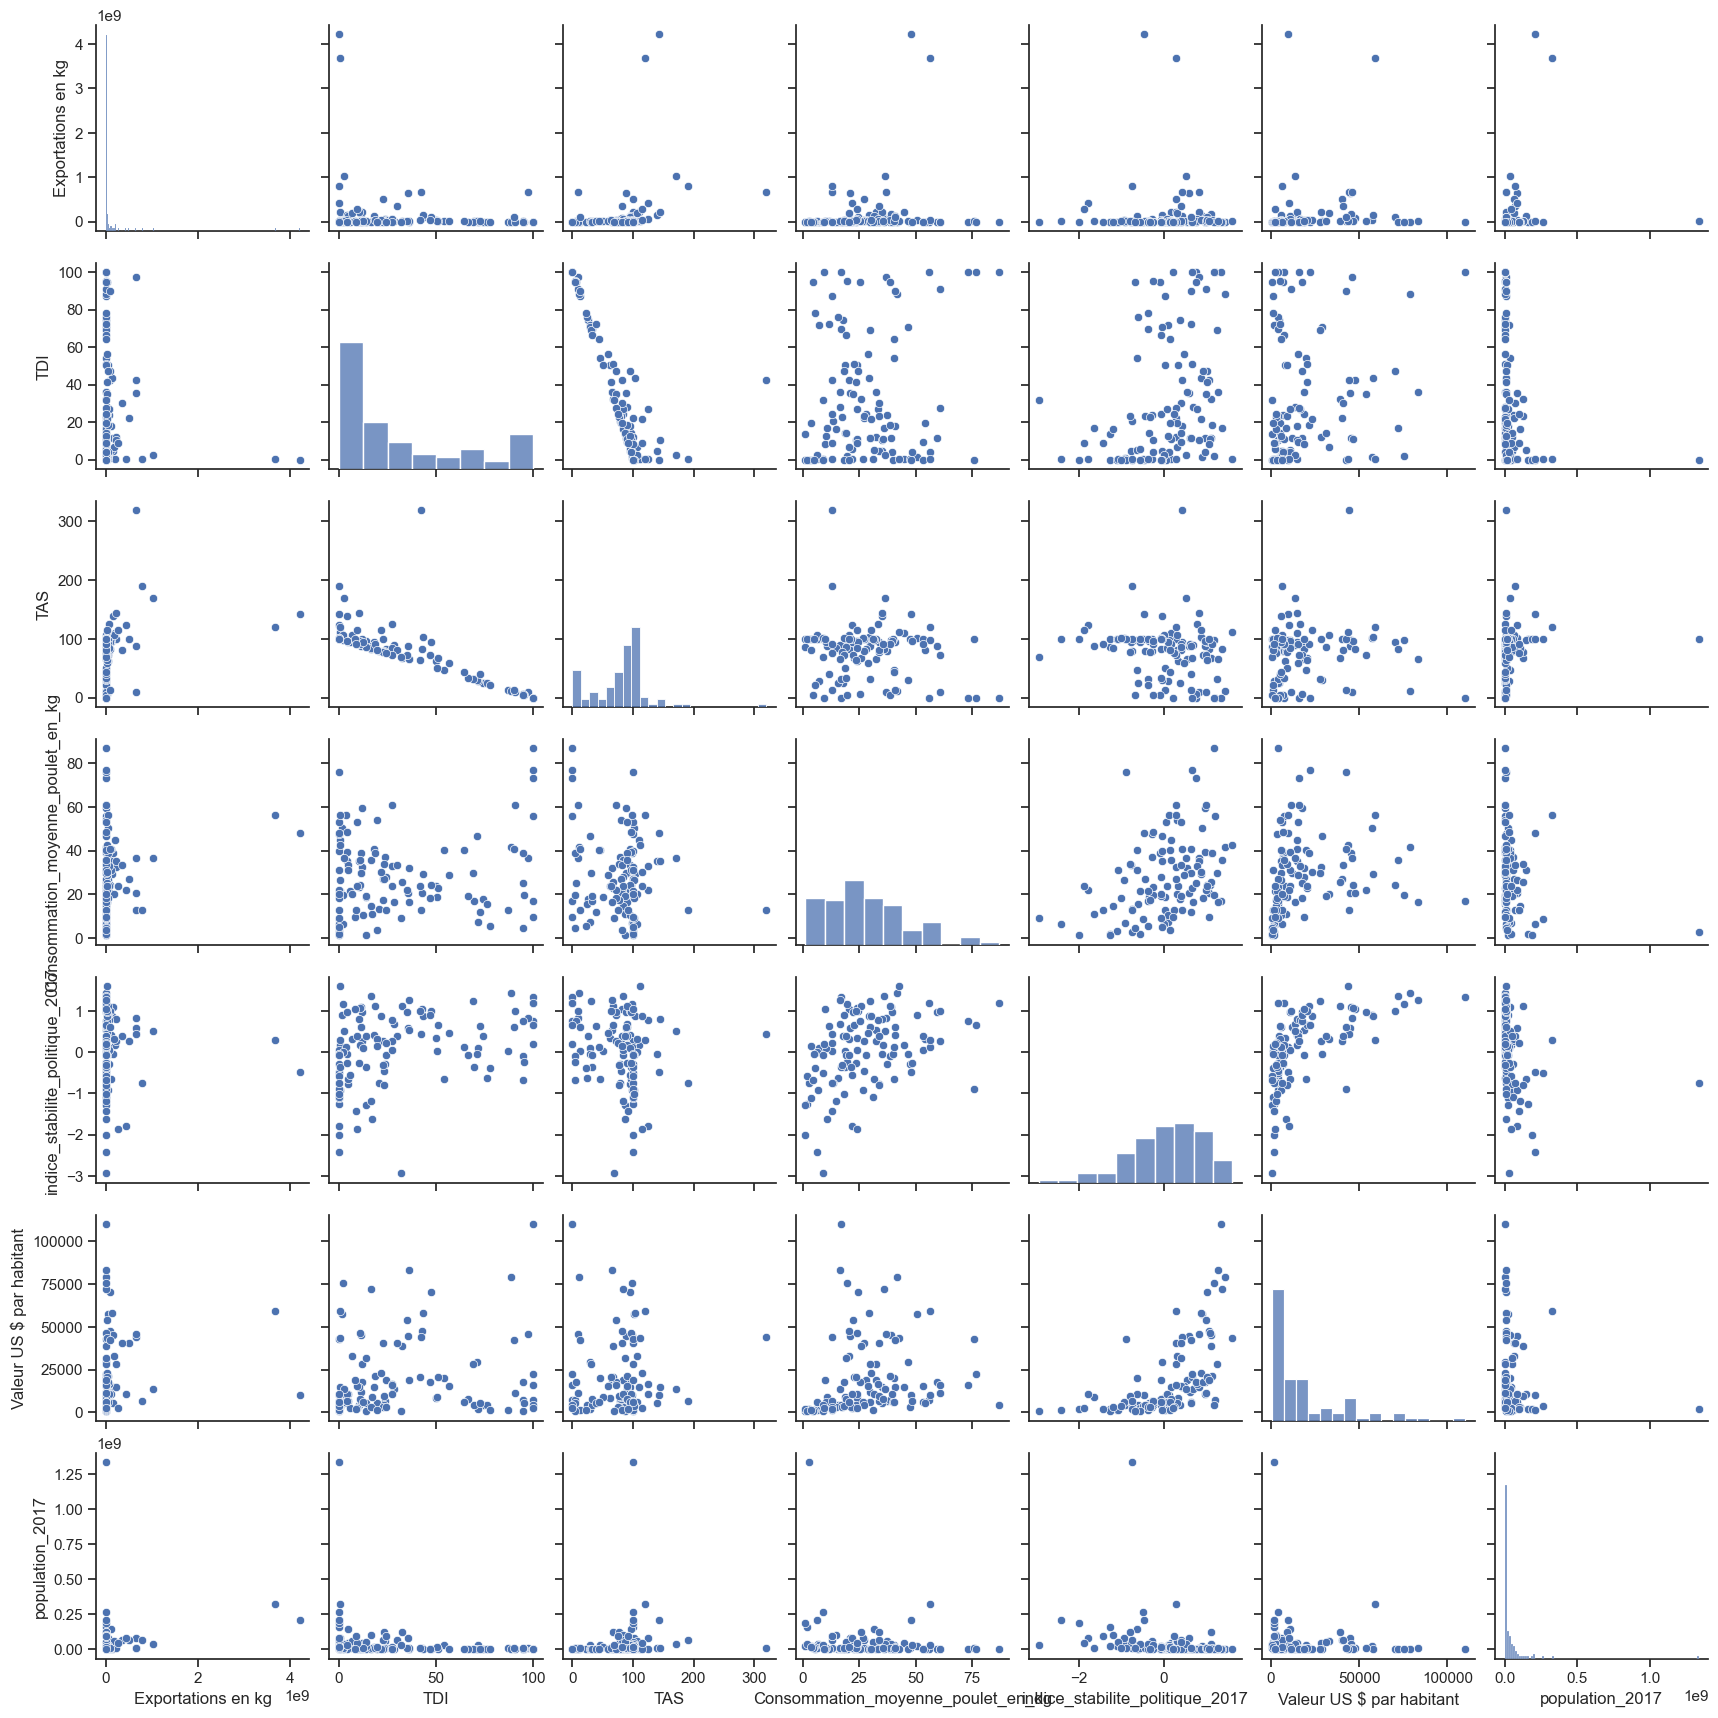

In [102]:
# Création d'un sous-ensemble de données avec les colonnes sélectionnées
subset_df = new_merged_df[selected_columns]

# Tracé du scatter plot
sns.pairplot(subset_df)
plt.show()


In [103]:
new_merged_df['Index'] = new_merged_df.index

fig = px.box(new_merged_df, y=selected_columns, hover_data=['Index'], labels={'variable': 'Features', 'value': 'Valeurs'})

fig.update_layout(title='Identification des outliers')

# Afficher le graphique
fig.show()


C:\Users\nbous\AppData\Local\Temp\ipykernel_21764\3932668174.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [104]:
new_merged_df = new_merged_df.drop(columns='Index')

C:\Users\nbous\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



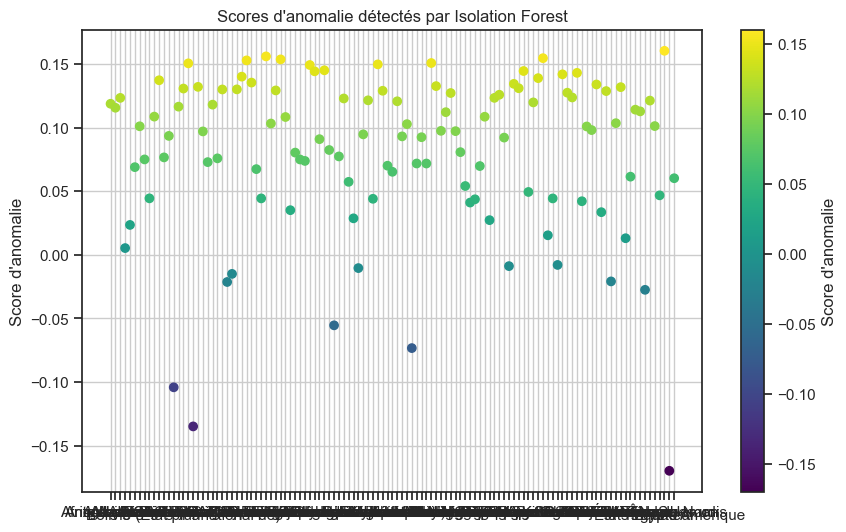

In [111]:
from sklearn.ensemble import IsolationForest

# Créer un modèle Isolation Forest
model = IsolationForest(contamination=0.10) # 10% d'anomalies

# Entraîner le modèle sur les données sélectionnées
model.fit(new_merged_df[selected_columns])

# Prédire les anomalies
anomaly_scores = model.decision_function(new_merged_df[selected_columns])

# Ajouter les scores d'anomalie au DataFrame
new_merged_df['AnomalyScore'] = anomaly_scores

# Afficher les points avec les scores d'anomalie
plt.figure(figsize=(10, 6))
plt.scatter(new_merged_df.index, new_merged_df['AnomalyScore'], c=new_merged_df['AnomalyScore'], cmap='viridis')
#plt.xlabel('Index')
plt.ylabel('Score d\'anomalie')
plt.title('Scores d\'anomalie détectés par Isolation Forest')
plt.colorbar(label='Score d\'anomalie')
plt.grid(True)
plt.show()


In [112]:
# Filtrer les données pour obtenir les outliers
outliers_df = new_merged_df[new_merged_df['AnomalyScore'] < 0]

# Afficher les outliers
print("Liste des outliers :")
print(outliers_df)


Liste des outliers :
                          Exportations en kg  population_2017   
Zone                                                            
Belgique                        6.560000e+08     1.141975e+07  \
Brésil                          4.223000e+09     2.078338e+08   
Chine - RAS de Hong-Kong        6.630000e+08     7.306322e+06   
Chine - RAS de Macao            0.000000e+00     6.225850e+05   
Inde                            4.000000e+06     1.338677e+09   
Israël                          3.000000e+06     8.243848e+06   
Luxembourg                      1.000000e+06     5.919100e+05   
Pologne                         1.025000e+09     3.795318e+07   
Samoa                           0.000000e+00     1.953520e+05   
Thaïlande                       7.960000e+08     6.920981e+07   
Yémen                           0.000000e+00     2.783482e+07   
États-Unis d'Amérique           3.692000e+09     3.250848e+08   

                          indice_stabilite_politique_2017   
Zone   

### <font color='pink'>8. Suppression des anomalies avec IsolationForest</font>

In [113]:
# Supprimer les lignes correspondant aux outliers du DataFrame
new_merged_df = new_merged_df.drop(outliers_df.index)

# Afficher le DataFrame sans les outliers
new_merged_df.shape


(105, 8)

In [114]:
df_numeric = new_merged_df.select_dtypes(include=[np.number])

# Créer une figure avec Plotly Express en spécifiant l'index comme étiquette au survol
fig = px.box(new_merged_df, y=df_numeric.columns, hover_name=new_merged_df.index)

# Afficher la figure
fig.show()


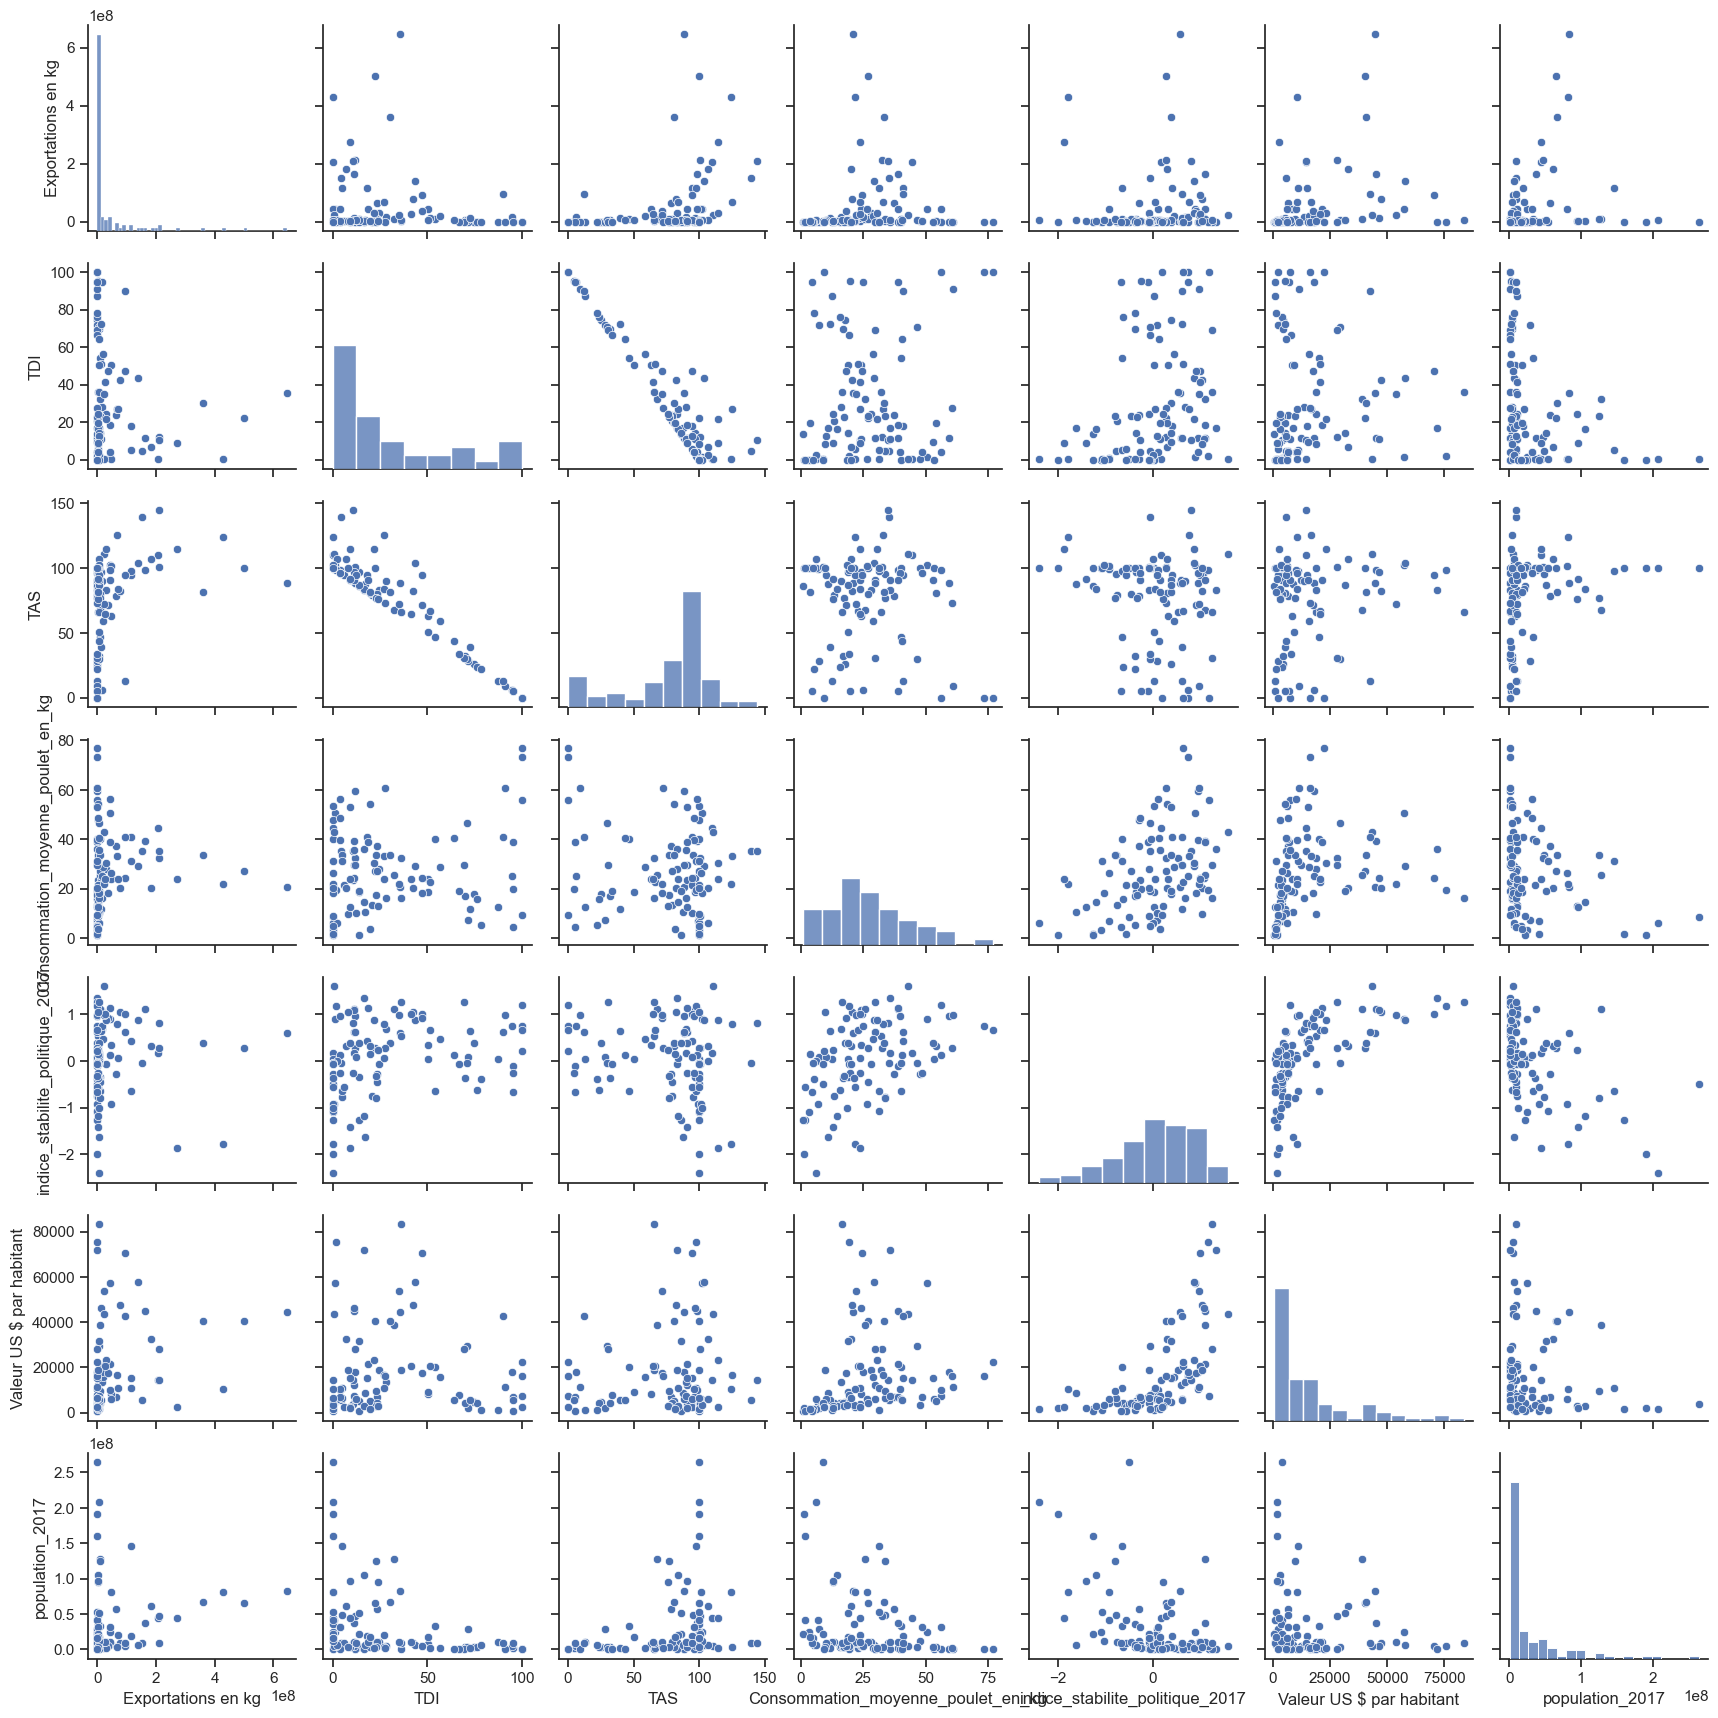

In [115]:
# Création d'un sous-ensemble de données avec les colonnes sélectionnées
subset_df = new_merged_df[selected_columns]

# Tracé du scatter plot
sns.pairplot(subset_df)
plt.show()


<font color='deepskyblue'>INFO : Pourquoi faut-il supprimer les outliers des données avant une ACP ?

Impact sur les résultats : Les outliers peuvent avoir un impact disproportionné sur les résultats de l'ACP en raison de leur grande distance par rapport au reste des données. Cela peut fausser la variance expliquée par chaque composante principale et donc la structure sous-jacente des données.

Stabilité des résultats : Les outliers peuvent rendre les résultats de l'ACP moins stables, car ils peuvent influencer fortement la position des axes principaux et la variance expliquée par chaque composante. En supprimant les outliers, on peut obtenir des résultats plus fiables et reproductibles.

Interprétation des résultats : Les outliers peuvent masquer la véritable structure des données et rendre difficile l'interprétation des composantes principales. En les éliminant, on peut mieux comprendre la structure des données et les relations entre les variables.

Sensibilité aux distances : L'ACP est sensible aux distances entre les observations. Les outliers peuvent introduire des distances disproportionnées qui ne représentent pas la véritable structure des données, ce qui peut conduire à des résultats trompeurs.

En résumé, en supprimant les outliers avant une ACP, on peut obtenir des résultats plus fiables, plus stables et plus facilement interprétables, en mettant en évidence la véritable structure des données. Cependant, la suppression des outliers doit être réalisée de manière prudente et justifiée, en tenant compte du contexte spécifique des données et des objectifs de l'analyse.</font>

In [116]:
print(new_merged_df.columns)
print(f'il y a :  {new_merged_df.shape[0]} lignes et {new_merged_df.shape[1]} colonnes')

Index(['Exportations en kg', 'population_2017',
       'indice_stabilite_politique_2017', 'Valeur US $ par habitant', 'TAS',
       'TDI', 'Consommation_moyenne_poulet_en_kg', 'AnomalyScore'],
      dtype='object')
il y a :  105 lignes et 8 colonnes


In [117]:
# Supprimer les colonnes "AnomalyScore" et "AnomalyScore2"
new_merged_df = new_merged_df.drop(columns=['AnomalyScore'])


======================================================================================================================================

### <font color='pink'>9. Enregistrement de notre dataframe nettoyé et préparé pour analyse multivariée</font>

In [118]:
new_merged_df.to_csv('cleaning_df2.csv', index=True)

<font color='lightgreen'>Analyse multivariée dans Notebook 2 :

=> K-means

=> CAH

=> ACP

</font>

<font color='yellow'>+++++++++++ CLEANED AND READY TO BE USED IN MULTIDIMENSIONAL ANALYSIS+++++++++++++</font>